In [ ]:
#| default_exp tycho2_main

importing dependencies

In [ ]:
#| export
import polars as pl
import numpy as np
import torch
import math
import time
import heapq
from typing import List, Any
import tqdm
import pickle
import pyarrow as pa
from dataclasses import dataclass, field

read the simplified tycho2 catalog

In [ ]:
df = pl.read_parquet('../support/tyc2-3.parquet')
print(df.describe())

shape: (9, 4)
┌────────────┬────────────┬────────────┬────────────┐
│ describe   ┆ RAmdeg     ┆ DEmdeg     ┆ Vmag       │
│ ---        ┆ ---        ┆ ---        ┆ ---        │
│ str        ┆ f64        ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════════╪════════════╡
│ count      ┆ 2.430468e6 ┆ 2.430468e6 ┆ 2.430468e6 │
│ null_count ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ mean       ┆ 188.530502 ┆ -3.479685  ┆ 11.071772  │
│ std        ┆ 100.340485 ┆ 41.43108   ┆ 1.108483   │
│ min        ┆ 0.000339   ┆ -89.889664 ┆ 1.89558    │
│ 25%        ┆ 105.471535 ┆ -39.00515  ┆ 10.54628   │
│ 50%        ┆ 186.052124 ┆ -4.889748  ┆ 11.292219  │
│ 75%        ┆ 280.987732 ┆ 31.3225    ┆ 11.82646   │
│ max        ┆ 359.999878 ┆ 89.832336  ┆ 15.37354   │
└────────────┴────────────┴────────────┴────────────┘


In [ ]:
#| export

@dataclass(order=True)
class ScoreItem:
    score: float
    region: int=field(compare=False)
    item: Any=field(compare=False)
    
@dataclass(order=True)
class Points:
    points: Any=field(compare=False)
    

def convert_to_cartesian(distances, ra, dec):
    x = distances * torch.cos(dec) * torch.cos(ra)
    y = distances * torch.cos(dec) * torch.sin(ra)
    z = distances * torch.sin(dec)
    return torch.stack((x, y, z), dim=1)

def calculate_distances(coords):
    dist_matrix = torch.cdist(coords, coords)
    unique_distances = torch.unique(dist_matrix)
    return unique_distances[unique_distances > 0]

def distance_from_magnitude(m, M):
    return 10**((m - M + 5) / 5)

def distance_from_magnitude_tensor(m: torch.Tensor, M: torch.Tensor) -> torch.Tensor:
    return 10**((m - M + 5) / 5)

# one of the possibilities
def tetrahedron_score(coords):
    distances = calculate_distances(coords)
    print(distances)
    mean_distance = torch.mean(distances)
    std_dev = torch.std(distances)

    # Assuming std_dev is small enough, the score will be close to 1
    # Otherwise, it will be closer to 0
    score = math.exp(-std_dev.item() / mean_distance.item())
    return score

def square_score(tensor):
    """Return a measure of how close the points in a tensor are to forming a square,
    as well as the standard deviation of their brightness."""
    
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)
    print(spatial_distances)
    
    # Sort the distances
    sorted_distances = torch.sort(spatial_distances)[0]
    
    # Take the 4 smallest distances and compute their standard deviation
    std_of_smallest_4 = sorted_distances[:4].std().item()
    
    # # Calculate the standard deviation of the brightness (third dimension)
    # brightness_std = tensor[:, 2].std().item()
    
    return std_of_smallest_4

def measure_squareness_old(tensor):
    """
    :param points: A tensor of shape (4, 2) representing the 4 2D points
    :return: A float indicating the squareness. Closer to 1 means more square.
    """
    
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)

    # Sort the distances
    distances = torch.sort(spatial_distances)[0]
    
    # Mean of sides and diagonals
    mean_sides = torch.mean(distances[:4])
    mean_diagonal = torch.mean(distances[4:])
    
    # Squareness measure
    squareness = mean_diagonal / mean_sides
    
    # Normalize with sqrt(2) to get values closer to 1 for squares
    return abs(1 - (squareness / torch.sqrt(torch.tensor(2.0)).item()))

def measure_squareness(tensor):
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)

    # Sort the distances
    distances = torch.sort(spatial_distances)[0]
   
    # Compute the standard deviation for the four shortest distances and the two longest distances
    std_sides = torch.std(distances[:4])
    std_diagonal = torch.std(distances[4:])
    
    # Ideally, for a perfect square, the standard deviations would be 0
    # We use exp(-x) as a measure to get values close to 1 for low standard deviations
    side_uniformity = torch.exp(-std_sides)
    diagonal_uniformity = torch.exp(-std_diagonal)
    
    # Mean of sides and diagonals
    mean_sides = torch.mean(distances[:4])
    mean_diagonal = torch.mean(distances[4:])
    
    # Squareness measure based on side to diagonal ratio
    squareness_ratio = mean_sides / mean_diagonal
    
    # Combine all the measures
    # Normalize with sqrt(2) to get values closer to 1 for squares
    final_squareness = (squareness_ratio / torch.sqrt(torch.tensor(2.0)).item()) * side_uniformity * diagonal_uniformity
    
    return abs(1 - final_squareness.item())

def mass_score_triangle_torch(points_tensor, device='cpu'):
    points_tensor = points_tensor.to(device)  # Transfer tensor to GPU if available
    idx_combinations = torch.combinations(torch.arange(points_tensor.shape[0]), r=3)
    print(f"There are {len(idx_combinations)} combinations")
                                          
    p1, p2, p3 = points_tensor[idx_combinations[:, 0]], points_tensor[idx_combinations[:, 1]], points_tensor[idx_combinations[:, 2]]

    a = torch.linalg.norm(p2 - p1, dim=1)
    b = torch.linalg.norm(p3 - p2, dim=1)
    c = torch.linalg.norm(p1 - p3, dim=1)
    
    mean = (a + b + c) / 3
    std_dev = torch.sqrt(((a - mean)**2 + (b - mean)**2 + (c - mean)**2) / 3)
    
    scores = torch.where(mean != 0, std_dev / mean, torch.tensor([1.], device=mean.device))
    
     # Stack the points instead of flattening them
    points_combined = torch.stack([p1, p2, p3], dim=1)
    
    return scores, points_combined

# go from tycho2 to xyz coords
def transform_radecmag_from_numpy(stars):
    torch_tensors = [torch.from_numpy(star) for star in stars]
    zeroes = torch.zeros(len(torch_tensors[2]))
    print("one ", torch_tensors)
    torch_tensors[2] = distance_from_magnitude_tensor(torch_tensors[2], zeroes)
    print("two", torch_tensors)
    coords = convert_to_cartesian(*torch_tensors)
    return coords

def global_normalize_tensor(tensor):
    """Normalize a tensor based on its global min and max values. Also works for multiple tensors"""
    global_min = torch.min(tensor)
    global_max = torch.max(tensor)
    
    normalized = (tensor - global_min) / (global_max - global_min)
    return normalized
    
def radec_normalize_tensor(tensors):
    """Normalize tensors based on their global min and max values, excluding the 3rd column."""

    # Concatenate tensors while excluding the 3rd column
    # Drop the 3rd column from each tensor
    tensor = tensors[:, :2]

    # Compute global min and max excluding the 3rd column
    global_min = torch.min(tensor)
    global_max = torch.max(tensor)

    # Normalize tensors using the computed global min and max
    normalized = (tensor - global_min) / (global_max - global_min)
    return normalized

def mag_score(tensor):
    # Computing the standard deviation
    # stdev = t[:, 2].std()
    max = tensor[:, 2].max()
    min = tensor[:, 2].min()
    return max - min

def score_triangle(tensor):    
    # Calculate pairwise distances based on the x and y coordinates (first two dimensions)
    spatial_distances = torch.pdist(tensor, p=2)
    
    # Normalize with sqrt(2) to get values closer to 1 for squares
    return torch.std(spatial_distances)

def stars_for_point_and_radius(df, point, radius, max_mag):
    """ point is in the corner, not the center """
    ra, dec = point
    minra = ra
    maxra = ra + radius
    mindec = dec
    maxdec = dec + radius
    return df.filter((pl.col("RAmdeg") < maxra) & (pl.col("RAmdeg") > minra) & (pl.col("DEmdeg") < maxdec) & (pl.col("DEmdeg") > mindec) & (pl.col("Vmag") <= max_mag))

def stars_for_center_and_radius(df, center, radius, max_mag):
    ra, dec = center
    minra = ra - radius/2
    maxra = ra + radius/2
    mindec = dec - radius/2
    maxdec = dec + radius/2
    return df.filter((pl.col("RAmdeg") < maxra) & (pl.col("RAmdeg") > minra) & (pl.col("DEmdeg") < maxdec) & (pl.col("DEmdeg") > mindec) & (pl.col("Vmag") <= max_mag))


def get_grid_points(min_dec=-90, max_dec=90):
    RA_values = [ra for ra in range(0, 361, 4)]  # Increment by 4 for a 2-degree radius
    Dec_values = [dec for dec in range(min_dec, max_dec+1, 4)]  # Increment by 4 for a 2-degree radius
    grid_points = [(ra, dec) for ra in RA_values for dec in Dec_values]
    return grid_points

def get_grid_point_by_idx(idx):
    gp = get_grid_points()
    return gp[idx]

def get_region(df, idx, radius, max_mag, min_dec=-90, max_dec=90):
    center = get_grid_points(min_dec, max_dec)[idx]
    return stars_for_center_and_radius(df, center, radius, max_mag)

def get_center(dftycho, center, radius, max_mag):
    return stars_for_point_and_radius(dftycho, center, radius, max_mag)

def ra_to_hms(ra):
    if ra < 0.0:
        ra = ra + 360
    mm, hh = math.modf(ra / 15.0)
    _, mm = math.modf(mm * 60.0)
    ss = round(_ * 60.0)
    return hh, mm, ss

resultdf = pl.DataFrame({
    "score": pl.Float64,
    "region": pl.Int64,
    "item": []
})


    


## Code to process each region

In [ ]:
from itertools import combinations
from heapq import heappush, heappushpop

In [ ]:

first = lambda h: 2**h - 1      # H stands for level height
last = lambda h: first(h + 1)
level = lambda heap, h: heap[first(h):last(h)]
prepare = lambda e, field: str(e).center(field)
        
def process(stars, region, point, nr_stars) -> List[ScoreItem]:
    scores, points = mass_score_triangle_torch(torch.tensor(stars), device='mps')
    resultdf = pl.DataFrame({
    "score": scores.cpu().numpy(), 
    "region": [region] * len(scores),
    "points": points.cpu().numpy()})
    final_result_df = resultdf.top_k(5, by="score", descending=True)
    print(f"Processed {region=} - {point} for length {len(stars)} with {len(scores)=}")
    return final_result_df
        

## Code to save progress

In [ ]:
def add_to_result_and_save(resultdf, df: pl.DataFrame, filename):
    print("Saving result to", filename)
    for entry in df.rows():
        thisdf = pl.DataFrame({
            "score": entry[0], 
            "region": entry[1], 
            "stars": [entry[2].tolist()],
        })
        if resultdf.is_empty():
            resultdf = thisdf
        else:
            resultdf = pl.concat([resultdf, thisdf])
    resultdf.write_parquet(filename)
    return resultdf
# Define the schema
# Define the schema
schema = {
    "score": pl.Float64,
    "region": pl.Float64,
    "stars": pl.List(pl.List(pl.Float64))  # Nested list type
}

## Generate a grid of regions and process each region

In [ ]:
grid_points = get_grid_points(-63,63)
print("Total grid points is:", len(grid_points))

result_filename = 'result_triangle2.parquet'
# resultdf = pl.DataFrame()
# try:
#     resultdf = pl.read_parquet(result_filename)
# except:
#     print("no previoous results")
#     pass
# print(f"Loaded results: {resultdf.head()}")

def process_regions(grid, start=0, end=0):
    if end == 0:
        end = len(grid)
    
    zipped_list = list(zip(range(len(grid)), grid))
    grid_points = zipped_list[start:end]
    global_result = pl.DataFrame()

    result = []
    for idx, point in tqdm.tqdm(grid_points):
        stars = stars_for_point_and_radius(df, point=point, radius=2, max_mag=12)
        if len(stars) > 0:
            result = process(stars.rows(), idx, point, 3)
            if result is not None and not result.is_empty():
                if global_result.is_empty():
                    global_result = result
                else:
                    global_result = global_result.vstack(result)
            else:
                print("no results")
            print("************************")
        if idx % 1000 == 0:
        #if idx == len(grid_points)-1:
            print(global_result.sort("score").head(5) if not global_result.is_empty() else "no score")
            #global_result.map_rows(lambda t: (t[0] * 2, t[1] * 3))
            write_df = pl.DataFrame()
            points = global_result
            add_to_result_and_save(write_df, points, result_filename)
    #time.sleep(10)
%time process_regions(grid_points, start=0)

Total grid points is: 2912


  0%|                                                                                                                                                           | 0/2912 [00:00<?, ?it/s]

There are 18424 combinations
Processed region=0 - (0, -63) for length 49 with len(scores)=18424
************************
There are 16215 combinations
Processed region=1 - (0, -59) for length 47 with len(scores)=16215
************************
There are 13244 combinations
Processed region=2 - (0, -55) for length 44 with len(scores)=13244
************************
There are 23426 combinations
Processed region=3 - (0, -51) for length 53 with len(scores)=23426
************************
There are 45760 combinations
Processed region=4 - (0, -47) for length 66 with len(scores)=45760
************************
There are 70300 combinations


  0%|▍                                                                                                                                                  | 9/2912 [00:00<03:30, 13.79it/s]

Processed region=5 - (0, -43) for length 76 with len(scores)=70300
************************
There are 32509 combinations
Processed region=6 - (0, -39) for length 59 with len(scores)=32509
************************
There are 37820 combinations
Processed region=7 - (0, -35) for length 62 with len(scores)=37820
************************
There are 204156 combinations
Processed region=8 - (0, -31) for length 108 with len(scores)=204156
************************
There are 70300 combinations
Processed region=9 - (0, -27) for length 76 with len(scores)=70300
************************
There are 70300 combinations
Processed region=10 - (0, -23) for length 76 with len(scores)=70300
************************
There are 62196 combinations
Processed region=11 - (0, -19) for length 73 with len(scores)=62196
************************
There are 43680 combinations
Processed region=12 - (0, -15) for length 65 with len(scores)=43680
************************
There are 85320 combinations


  1%|▉                                                                                                                                                 | 18/2912 [00:00<02:04, 23.23it/s]

Processed region=13 - (0, -11) for length 81 with len(scores)=85320
************************
There are 134044 combinations
Processed region=14 - (0, -7) for length 94 with len(scores)=134044
************************
There are 98770 combinations
Processed region=15 - (0, -3) for length 85 with len(scores)=98770
************************
There are 138415 combinations
Processed region=16 - (0, 1) for length 95 with len(scores)=138415
************************
There are 156849 combinations
Processed region=17 - (0, 5) for length 99 with len(scores)=156849
************************
There are 76076 combinations
Processed region=18 - (0, 9) for length 78 with len(scores)=76076
************************
There are 142880 combinations
Processed region=19 - (0, 13) for length 96 with len(scores)=142880
************************


  1%|█                                                                                                                                                 | 22/2912 [00:01<02:03, 23.38it/s]

There are 152096 combinations
Processed region=20 - (0, 17) for length 98 with len(scores)=152096
************************
There are 280840 combinations
Processed region=21 - (0, 21) for length 120 with len(scores)=280840
************************
There are 234136 combinations
Processed region=22 - (0, 25) for length 113 with len(scores)=234136
************************
There are 596904 combinations
Processed region=23 - (0, 29) for length 154 with len(scores)=596904
************************
There are 682640 combinations


  1%|█▎                                                                                                                                                | 25/2912 [00:01<03:22, 14.28it/s]

Processed region=24 - (0, 33) for length 161 with len(scores)=682640
************************
There are 467180 combinations
Processed region=25 - (0, 37) for length 142 with len(scores)=467180
************************
There are 632710 combinations
Processed region=26 - (0, 41) for length 157 with len(scores)=632710
************************
There are 1293699 combinations


  1%|█▍                                                                                                                                                | 28/2912 [00:02<05:08,  9.35it/s]

Processed region=27 - (0, 45) for length 199 with len(scores)=1293699
************************
There are 1823471 combinations
Processed region=28 - (0, 49) for length 223 with len(scores)=1823471
************************
There are 2481115 combinations


  1%|█▌                                                                                                                                                | 30/2912 [00:03<09:03,  5.30it/s]

Processed region=29 - (0, 53) for length 247 with len(scores)=2481115
************************
There are 1949476 combinations
Processed region=30 - (0, 57) for length 228 with len(scores)=1949476
************************
There are 1565620 combinations


  1%|██                                                                                                                                                | 40/2912 [00:04<05:09,  9.27it/s]

Processed region=31 - (0, 61) for length 212 with len(scores)=1565620
************************
There are 30856 combinations
Processed region=32 - (4, -63) for length 58 with len(scores)=30856
************************
There are 13244 combinations
Processed region=33 - (4, -59) for length 44 with len(scores)=13244
************************
There are 57155 combinations
Processed region=34 - (4, -55) for length 71 with len(scores)=57155
************************
There are 26235 combinations
Processed region=35 - (4, -51) for length 55 with len(scores)=26235
************************
There are 29260 combinations
Processed region=36 - (4, -47) for length 57 with len(scores)=29260
************************
There are 26235 combinations
Processed region=37 - (4, -43) for length 55 with len(scores)=26235
************************
There are 64824 combinations
Processed region=38 - (4, -39) for length 74 with len(scores)=64824
************************
There are 39711 combinations
Processed region=39 - 

  2%|██▌                                                                                                                                               | 50/2912 [00:04<02:58, 16.08it/s]

There are 37820 combinations
Processed region=43 - (4, -19) for length 62 with len(scores)=37820
************************
There are 105995 combinations
Processed region=44 - (4, -15) for length 87 with len(scores)=105995
************************
There are 59640 combinations
Processed region=45 - (4, -11) for length 72 with len(scores)=59640
************************
There are 79079 combinations
Processed region=46 - (4, -7) for length 79 with len(scores)=79079
************************
There are 102340 combinations
Processed region=47 - (4, -3) for length 86 with len(scores)=102340
************************
There are 113564 combinations
Processed region=48 - (4, 1) for length 89 with len(scores)=113564
************************
There are 113564 combinations
Processed region=49 - (4, 5) for length 89 with len(scores)=113564
************************
There are 125580 combinations
Processed region=50 - (4, 9) for length 92 with len(scores)=125580
************************


  2%|██▋                                                                                                                                               | 54/2912 [00:04<02:39, 17.90it/s]

There are 59640 combinations
Processed region=51 - (4, 13) for length 72 with len(scores)=59640
************************
There are 138415 combinations
Processed region=52 - (4, 17) for length 95 with len(scores)=138415
************************
There are 317750 combinations
Processed region=53 - (4, 21) for length 125 with len(scores)=317750
************************
There are 383306 combinations
Processed region=54 - (4, 25) for length 133 with len(scores)=383306
************************
There are 341376 combinations
Processed region=55 - (4, 29) for length 128 with len(scores)=341376
************************
There are 349504 combinations
Processed region=56 - (4, 33) for length 129 with len(scores)=349504
************************


  2%|██▉                                                                                                                                               | 58/2912 [00:04<03:23, 14.06it/s]

There are 762355 combinations
Processed region=57 - (4, 37) for length 167 with len(scores)=762355
************************
There are 573800 combinations
Processed region=58 - (4, 41) for length 152 with len(scores)=573800
************************
There are 1198144 combinations
Processed region=59 - (4, 45) for length 194 with len(scores)=1198144
************************
There are 1543465 combinations


  2%|███                                                                                                                                               | 61/2912 [00:05<05:27,  8.70it/s]

Processed region=60 - (4, 49) for length 211 with len(scores)=1543465
************************
There are 3317040 combinations
Processed region=61 - (4, 53) for length 272 with len(scores)=3317040
************************
There are 2001460 combinations


  2%|███▏                                                                                                                                              | 63/2912 [00:06<10:07,  4.69it/s]

Processed region=62 - (4, 57) for length 230 with len(scores)=2001460
************************
There are 2604125 combinations


  2%|███▌                                                                                                                                              | 72/2912 [00:07<05:53,  8.04it/s]

Processed region=63 - (4, 61) for length 251 with len(scores)=2604125
************************
There are 11480 combinations
Processed region=64 - (8, -63) for length 42 with len(scores)=11480
************************
There are 35990 combinations
Processed region=65 - (8, -59) for length 61 with len(scores)=35990
************************
There are 29260 combinations
Processed region=66 - (8, -55) for length 57 with len(scores)=29260
************************
There are 57155 combinations
Processed region=67 - (8, -51) for length 71 with len(scores)=57155
************************
There are 14190 combinations
Processed region=68 - (8, -47) for length 45 with len(scores)=14190
************************
There are 34220 combinations
Processed region=69 - (8, -43) for length 60 with len(scores)=34220
************************
There are 50116 combinations
Processed region=70 - (8, -39) for length 68 with len(scores)=50116
************************
There are 30856 combinations
Processed region=71 - 

  3%|████                                                                                                                                              | 82/2912 [00:07<03:17, 14.33it/s]

There are 98770 combinations
Processed region=76 - (8, -15) for length 85 with len(scores)=98770
************************
There are 102340 combinations
Processed region=77 - (8, -11) for length 86 with len(scores)=102340
************************
There are 47905 combinations
Processed region=78 - (8, -7) for length 67 with len(scores)=47905
************************
There are 35990 combinations
Processed region=79 - (8, -3) for length 61 with len(scores)=35990
************************
There are 166650 combinations
Processed region=80 - (8, 1) for length 101 with len(scores)=166650
************************
There are 166650 combinations
Processed region=81 - (8, 5) for length 101 with len(scores)=166650
************************
There are 64824 combinations
Processed region=82 - (8, 9) for length 74 with len(scores)=64824
************************
There are 125580 combinations


  3%|████▎                                                                                                                                             | 86/2912 [00:08<02:58, 15.83it/s]

Processed region=83 - (8, 13) for length 92 with len(scores)=125580
************************
There are 176851 combinations
Processed region=84 - (8, 17) for length 103 with len(scores)=176851
************************
There are 325500 combinations
Processed region=85 - (8, 21) for length 126 with len(scores)=325500
************************
There are 287980 combinations
Processed region=86 - (8, 25) for length 121 with len(scores)=287980


  3%|████▍                                                                                                                                             | 89/2912 [00:08<03:12, 14.69it/s]

************************
There are 310124 combinations
Processed region=87 - (8, 29) for length 124 with len(scores)=310124
************************
There are 400995 combinations
Processed region=88 - (8, 33) for length 135 with len(scores)=400995
************************
There are 748660 combinations
Processed region=89 - (8, 37) for length 166 with len(scores)=748660
************************
There are 657359 combinations
Processed region=90 - (8, 41) for length 159 with len(scores)=657359
************************
There are 1143135 combinations


  3%|████▌                                                                                                                                             | 92/2912 [00:09<04:50,  9.72it/s]

Processed region=91 - (8, 45) for length 191 with len(scores)=1143135
************************
There are 1478256 combinations
Processed region=92 - (8, 49) for length 208 with len(scores)=1478256
************************
There are 1435820 combinations


  3%|████▋                                                                                                                                             | 94/2912 [00:09<07:07,  6.59it/s]

Processed region=93 - (8, 53) for length 206 with len(scores)=1435820
************************
There are 3066580 combinations
Processed region=94 - (8, 57) for length 265 with len(scores)=3066580
************************
There are 1823471 combinations


  4%|█████▏                                                                                                                                           | 103/2912 [00:11<06:09,  7.61it/s]

Processed region=95 - (8, 61) for length 223 with len(scores)=1823471
************************
There are 19600 combinations
Processed region=96 - (12, -63) for length 50 with len(scores)=19600
************************
There are 37820 combinations
Processed region=97 - (12, -59) for length 62 with len(scores)=37820
************************
There are 16215 combinations
Processed region=98 - (12, -55) for length 47 with len(scores)=16215
************************
There are 62196 combinations
Processed region=99 - (12, -51) for length 73 with len(scores)=62196
************************
There are 19600 combinations
Processed region=100 - (12, -47) for length 50 with len(scores)=19600
************************
There are 41664 combinations
Processed region=101 - (12, -43) for length 64 with len(scores)=41664
************************
There are 85320 combinations
Processed region=102 - (12, -39) for length 81 with len(scores)=85320
************************
There are 39711 combinations
Processed re

  4%|█████▋                                                                                                                                           | 114/2912 [00:11<03:09, 14.77it/s]

There are 59640 combinations
Processed region=107 - (12, -19) for length 72 with len(scores)=59640
************************
There are 57155 combinations
Processed region=108 - (12, -15) for length 71 with len(scores)=57155
************************
There are 82160 combinations
Processed region=109 - (12, -11) for length 80 with len(scores)=82160
************************
There are 47905 combinations
Processed region=110 - (12, -7) for length 67 with len(scores)=47905
************************
There are 67525 combinations
Processed region=111 - (12, -3) for length 75 with len(scores)=67525
************************
There are 82160 combinations
Processed region=112 - (12, 1) for length 80 with len(scores)=82160
************************
There are 82160 combinations
Processed region=113 - (12, 5) for length 80 with len(scores)=82160
************************
There are 113564 combinations
Processed region=114 - (12, 9) for length 89 with len(scores)=113564
************************
There are 8856

  4%|█████▉                                                                                                                                           | 118/2912 [00:11<02:47, 16.65it/s]

Processed region=115 - (12, 13) for length 82 with len(scores)=88560
************************
There are 182104 combinations
Processed region=116 - (12, 17) for length 104 with len(scores)=182104
************************
There are 198485 combinations
Processed region=117 - (12, 21) for length 107 with len(scores)=198485
************************
There are 221815 combinations
Processed region=118 - (12, 25) for length 111 with len(scores)=221815
************************
There are 428536 combinations
Processed region=119 - (12, 29) for length 138 with len(scores)=428536
************************
There are 419220 combinations
Processed region=120 - (12, 33) for length 137 with len(scores)=419220
************************


  4%|██████                                                                                                                                           | 122/2912 [00:12<03:45, 12.36it/s]

There are 804440 combinations
Processed region=121 - (12, 37) for length 170 with len(scores)=804440
************************
There are 818805 combinations
Processed region=122 - (12, 41) for length 171 with len(scores)=818805
************************
There are 924176 combinations
Processed region=123 - (12, 45) for length 178 with len(scores)=924176
************************
There are 2162940 combinations


  4%|██████▏                                                                                                                                          | 125/2912 [00:13<06:25,  7.23it/s]

Processed region=124 - (12, 49) for length 236 with len(scores)=2162940
************************
There are 2001460 combinations
Processed region=125 - (12, 53) for length 230 with len(scores)=2001460
************************
There are 2421090 combinations


  4%|██████▎                                                                                                                                          | 127/2912 [00:14<09:28,  4.89it/s]

Processed region=126 - (12, 57) for length 245 with len(scores)=2421090
************************
There are 939929 combinations


  4%|██████▍                                                                                                                                          | 129/2912 [00:14<08:59,  5.16it/s]

Processed region=127 - (12, 61) for length 179 with len(scores)=939929
************************
There are 9139 combinations
Processed region=128 - (16, -63) for length 39 with len(scores)=9139
************************
There are 39711 combinations
Processed region=129 - (16, -59) for length 63 with len(scores)=39711
************************
There are 22100 combinations
Processed region=130 - (16, -55) for length 52 with len(scores)=22100
************************
There are 30856 combinations
Processed region=131 - (16, -51) for length 58 with len(scores)=30856
************************
There are 20825 combinations


  5%|██████▉                                                                                                                                          | 139/2912 [00:14<03:52, 11.91it/s]

Processed region=132 - (16, -47) for length 51 with len(scores)=20825
************************
There are 57155 combinations
Processed region=133 - (16, -43) for length 71 with len(scores)=57155
************************
There are 57155 combinations
Processed region=134 - (16, -39) for length 71 with len(scores)=57155
************************
There are 43680 combinations
Processed region=135 - (16, -35) for length 65 with len(scores)=43680
************************
There are 29260 combinations
Processed region=136 - (16, -31) for length 57 with len(scores)=29260
************************
There are 70300 combinations
Processed region=137 - (16, -27) for length 76 with len(scores)=70300
************************
There are 59640 combinations
Processed region=138 - (16, -23) for length 72 with len(scores)=59640
************************
There are 82160 combinations
Processed region=139 - (16, -19) for length 80 with len(scores)=82160
************************
There are 70300 combinations
Processe

  5%|███████                                                                                                                                          | 143/2912 [00:14<03:05, 14.97it/s]

Processed region=142 - (16, -7) for length 68 with len(scores)=50116
************************
There are 52394 combinations
Processed region=143 - (16, -3) for length 69 with len(scores)=52394
************************
There are 209934 combinations
Processed region=144 - (16, 1) for length 109 with len(scores)=209934
************************
There are 109736 combinations
Processed region=145 - (16, 5) for length 88 with len(scores)=109736
************************
There are 91881 combinations


  5%|███████▍                                                                                                                                         | 150/2912 [00:15<03:00, 15.33it/s]

Processed region=146 - (16, 9) for length 83 with len(scores)=91881
************************
There are 98770 combinations
Processed region=147 - (16, 13) for length 85 with len(scores)=98770
************************
There are 204156 combinations
Processed region=148 - (16, 17) for length 108 with len(scores)=204156
************************
There are 246905 combinations
Processed region=149 - (16, 21) for length 115 with len(scores)=246905
************************
There are 187460 combinations
Processed region=150 - (16, 25) for length 105 with len(scores)=187460
************************
There are 280840 combinations
Processed region=151 - (16, 29) for length 120 with len(scores)=280840
************************


  5%|███████▌                                                                                                                                         | 153/2912 [00:15<03:43, 12.36it/s]

There are 620620 combinations
Processed region=152 - (16, 33) for length 156 with len(scores)=620620
************************
There are 955860 combinations
Processed region=153 - (16, 37) for length 180 with len(scores)=955860
************************


  5%|███████▋                                                                                                                                         | 155/2912 [00:16<05:18,  8.66it/s]

There are 721764 combinations
Processed region=154 - (16, 41) for length 164 with len(scores)=721764
************************
There are 1125180 combinations
Processed region=155 - (16, 45) for length 190 with len(scores)=1125180
************************
There are 1456935 combinations


  5%|███████▊                                                                                                                                         | 157/2912 [00:16<08:08,  5.64it/s]

Processed region=156 - (16, 49) for length 207 with len(scores)=1456935
************************
There are 1072445 combinations
Processed region=157 - (16, 53) for length 187 with len(scores)=1072445
************************
There are 1679580 combinations


  5%|███████▉                                                                                                                                         | 159/2912 [00:17<10:20,  4.43it/s]

Processed region=158 - (16, 57) for length 217 with len(scores)=1679580
************************
There are 762355 combinations


  6%|████████▏                                                                                                                                        | 164/2912 [00:17<06:19,  7.24it/s]

Processed region=159 - (16, 61) for length 167 with len(scores)=762355
************************
There are 20825 combinations
Processed region=160 - (20, -63) for length 51 with len(scores)=20825
************************
There are 14190 combinations
Processed region=161 - (20, -59) for length 45 with len(scores)=14190
************************
There are 24804 combinations
Processed region=162 - (20, -55) for length 54 with len(scores)=24804
************************
There are 27720 combinations
Processed region=163 - (20, -51) for length 56 with len(scores)=27720
************************
There are 39711 combinations
Processed region=164 - (20, -47) for length 63 with len(scores)=39711
************************
There are 64824 combinations
Processed region=165 - (20, -43) for length 74 with len(scores)=64824
************************
There are 24804 combinations
Processed region=166 - (20, -39) for length 54 with len(scores)=24804
************************
There are 52394 combinations


  6%|████████▋                                                                                                                                        | 175/2912 [00:18<02:37, 17.38it/s]

Processed region=167 - (20, -35) for length 69 with len(scores)=52394
************************
There are 37820 combinations
Processed region=168 - (20, -31) for length 62 with len(scores)=37820
************************
There are 43680 combinations
Processed region=169 - (20, -27) for length 65 with len(scores)=43680
************************
There are 30856 combinations
Processed region=170 - (20, -23) for length 58 with len(scores)=30856
************************
There are 113564 combinations
Processed region=171 - (20, -19) for length 89 with len(scores)=113564
************************
There are 91881 combinations
Processed region=172 - (20, -15) for length 83 with len(scores)=91881
************************
There are 67525 combinations
Processed region=173 - (20, -11) for length 75 with len(scores)=67525
************************
There are 47905 combinations
Processed region=174 - (20, -7) for length 67 with len(scores)=47905
************************
There are 138415 combinations
Proces

  6%|████████▉                                                                                                                                        | 179/2912 [00:18<02:33, 17.76it/s]

Processed region=176 - (20, 1) for length 86 with len(scores)=102340
************************
There are 156849 combinations
Processed region=177 - (20, 5) for length 99 with len(scores)=156849
************************
There are 192920 combinations
Processed region=178 - (20, 9) for length 106 with len(scores)=192920
************************
There are 117480 combinations


  6%|█████████                                                                                                                                        | 182/2912 [00:18<02:33, 17.75it/s]

Processed region=179 - (20, 13) for length 90 with len(scores)=117480
************************
There are 113564 combinations
Processed region=180 - (20, 17) for length 89 with len(scores)=113564
************************
There are 182104 combinations
Processed region=181 - (20, 21) for length 104 with len(scores)=182104
************************
There are 209934 combinations
Processed region=182 - (20, 25) for length 109 with len(scores)=209934
************************
There are 366145 combinations


  6%|█████████▏                                                                                                                                       | 185/2912 [00:18<03:24, 13.36it/s]

Processed region=183 - (20, 29) for length 131 with len(scores)=366145
************************
There are 508080 combinations
Processed region=184 - (20, 33) for length 146 with len(scores)=508080
************************
There are 1038220 combinations
Processed region=185 - (20, 37) for length 185 with len(scores)=1038220
************************
There are 971970 combinations
Processed region=186 - (20, 41) for length 181 with len(scores)=971970
************************
There are 1125180 combinations


  6%|█████████▎                                                                                                                                       | 188/2912 [00:19<06:13,  7.28it/s]

Processed region=187 - (20, 45) for length 190 with len(scores)=1125180
************************
There are 848046 combinations
Processed region=188 - (20, 49) for length 173 with len(scores)=848046
************************
There are 939929 combinations


  7%|█████████▍                                                                                                                                       | 190/2912 [00:20<07:15,  6.25it/s]

Processed region=189 - (20, 53) for length 179 with len(scores)=939929
************************
There are 2027795 combinations
Processed region=190 - (20, 57) for length 231 with len(scores)=2027795
************************
There are 804440 combinations


  7%|█████████▋                                                                                                                                       | 194/2912 [00:21<07:51,  5.77it/s]

Processed region=191 - (20, 61) for length 170 with len(scores)=804440
************************
There are 7140 combinations
Processed region=192 - (24, -63) for length 36 with len(scores)=7140
************************
There are 14190 combinations
Processed region=193 - (24, -59) for length 45 with len(scores)=14190
************************
There are 19600 combinations
Processed region=194 - (24, -55) for length 50 with len(scores)=19600
************************
There are 32509 combinations
Processed region=195 - (24, -51) for length 59 with len(scores)=32509
************************
There are 26235 combinations
Processed region=196 - (24, -47) for length 55 with len(scores)=26235
************************
There are 41664 combinations
Processed region=197 - (24, -43) for length 64 with len(scores)=41664
************************
There are 98770 combinations
Processed region=198 - (24, -39) for length 85 with len(scores)=98770
************************
There are 47905 combinations


  7%|██████████▏                                                                                                                                      | 205/2912 [00:21<03:01, 14.95it/s]

Processed region=199 - (24, -35) for length 67 with len(scores)=47905
************************
There are 45760 combinations
Processed region=200 - (24, -31) for length 66 with len(scores)=45760
************************
There are 91881 combinations
Processed region=201 - (24, -27) for length 83 with len(scores)=91881
************************
There are 79079 combinations
Processed region=202 - (24, -23) for length 79 with len(scores)=79079
************************
There are 91881 combinations
Processed region=203 - (24, -19) for length 83 with len(scores)=91881
************************
There are 79079 combinations
Processed region=204 - (24, -15) for length 79 with len(scores)=79079
************************
There are 59640 combinations
Processed region=205 - (24, -11) for length 72 with len(scores)=59640
************************
There are 79079 combinations
Processed region=206 - (24, -7) for length 79 with len(scores)=79079
************************
There are 109736 combinations
Processe

  7%|██████████▍                                                                                                                                      | 210/2912 [00:21<02:22, 18.98it/s]

Processed region=208 - (24, 1) for length 86 with len(scores)=102340
************************
There are 156849 combinations
Processed region=209 - (24, 5) for length 99 with len(scores)=156849
************************
There are 147440 combinations
Processed region=210 - (24, 9) for length 97 with len(scores)=147440
************************
There are 156849 combinations
Processed region=211 - (24, 13) for length 99 with len(scores)=156849
************************
There are 187460 combinations


  7%|██████████▋                                                                                                                                      | 214/2912 [00:21<02:38, 17.05it/s]

Processed region=212 - (24, 17) for length 105 with len(scores)=187460
************************
There are 171700 combinations
Processed region=213 - (24, 21) for length 102 with len(scores)=171700
************************
There are 117480 combinations
Processed region=214 - (24, 25) for length 90 with len(scores)=117480
************************
There are 400995 combinations


  7%|██████████▊                                                                                                                                      | 217/2912 [00:22<03:10, 14.17it/s]

Processed region=215 - (24, 29) for length 135 with len(scores)=400995
************************
There are 748660 combinations
Processed region=216 - (24, 33) for length 166 with len(scores)=748660
************************
There are 988260 combinations
Processed region=217 - (24, 37) for length 182 with len(scores)=988260
************************
There are 776216 combinations
Processed region=218 - (24, 41) for length 168 with len(scores)=776216
************************
There are 1414910 combinations


  8%|██████████▉                                                                                                                                      | 220/2912 [00:23<06:10,  7.27it/s]

Processed region=219 - (24, 45) for length 205 with len(scores)=1414910
************************
There are 632710 combinations
Processed region=220 - (24, 49) for length 157 with len(scores)=632710
************************
There are 1610564 combinations


  8%|███████████                                                                                                                                      | 222/2912 [00:23<07:41,  5.82it/s]

Processed region=221 - (24, 53) for length 214 with len(scores)=1610564
************************
There are 2604125 combinations
Processed region=222 - (24, 57) for length 251 with len(scores)=2604125
************************
There are 1333300 combinations


  8%|███████████▌                                                                                                                                     | 231/2912 [00:25<05:55,  7.53it/s]

Processed region=223 - (24, 61) for length 201 with len(scores)=1333300
************************
There are 14190 combinations
Processed region=224 - (28, -63) for length 45 with len(scores)=14190
************************
There are 29260 combinations
Processed region=225 - (28, -59) for length 57 with len(scores)=29260
************************
There are 16215 combinations
Processed region=226 - (28, -55) for length 47 with len(scores)=16215
************************
There are 32509 combinations
Processed region=227 - (28, -51) for length 59 with len(scores)=32509
************************
There are 27720 combinations
Processed region=228 - (28, -47) for length 56 with len(scores)=27720
************************
There are 20825 combinations
Processed region=229 - (28, -43) for length 51 with len(scores)=20825
************************
There are 59640 combinations
Processed region=230 - (28, -39) for length 72 with len(scores)=59640
************************
There are 82160 combinations
Proces

  8%|████████████                                                                                                                                     | 241/2912 [00:25<03:08, 14.15it/s]

Processed region=233 - (28, -27) for length 77 with len(scores)=73150
************************
There are 73150 combinations
Processed region=234 - (28, -23) for length 77 with len(scores)=73150
************************
There are 52394 combinations
Processed region=235 - (28, -19) for length 69 with len(scores)=52394
************************
There are 73150 combinations
Processed region=236 - (28, -15) for length 77 with len(scores)=73150
************************
There are 95284 combinations
Processed region=237 - (28, -11) for length 84 with len(scores)=95284
************************
There are 67525 combinations
Processed region=238 - (28, -7) for length 75 with len(scores)=67525
************************
There are 85320 combinations
Processed region=239 - (28, -3) for length 81 with len(scores)=85320
************************
There are 102340 combinations
Processed region=240 - (28, 1) for length 86 with len(scores)=102340
************************
There are 95284 combinations
Processed 

  8%|████████████▏                                                                                                                                    | 245/2912 [00:25<02:39, 16.71it/s]

There are 109736 combinations
Processed region=243 - (28, 13) for length 88 with len(scores)=109736
************************
There are 204156 combinations
Processed region=244 - (28, 17) for length 108 with len(scores)=204156
************************
There are 152096 combinations
Processed region=245 - (28, 21) for length 98 with len(scores)=152096
************************
There are 234136 combinations
Processed region=246 - (28, 25) for length 113 with len(scores)=234136
************************
There are 349504 combinations
Processed region=247 - (28, 29) for length 129 with len(scores)=349504
************************
There are 487344 combinations


  9%|████████████▍                                                                                                                                    | 249/2912 [00:25<03:10, 14.00it/s]

Processed region=248 - (28, 33) for length 144 with len(scores)=487344
************************
There are 3317040 combinations
Processed region=249 - (28, 37) for length 272 with len(scores)=3317040
************************
There are 1143135 combinations
Processed region=250 - (28, 41) for length 191 with len(scores)=1143135
************************
There are 1949476 combinations


  9%|████████████▌                                                                                                                                    | 252/2912 [00:27<08:21,  5.30it/s]

Processed region=251 - (28, 45) for length 228 with len(scores)=1949476
************************
There are 735130 combinations
Processed region=252 - (28, 49) for length 165 with len(scores)=735130
************************
There are 3172316 combinations


  9%|████████████▋                                                                                                                                    | 254/2912 [00:28<11:30,  3.85it/s]

Processed region=253 - (28, 53) for length 268 with len(scores)=3172316
************************
There are 3619560 combinations
Processed region=254 - (28, 57) for length 280 with len(scores)=3619560
************************
There are 862924 combinations


  9%|████████████▊                                                                                                                                    | 258/2912 [00:30<13:47,  3.21it/s]

Processed region=255 - (28, 61) for length 174 with len(scores)=862924
************************
There are 7770 combinations
Processed region=256 - (32, -63) for length 37 with len(scores)=7770
************************
There are 22100 combinations
Processed region=257 - (32, -59) for length 52 with len(scores)=22100
************************
There are 27720 combinations
Processed region=258 - (32, -55) for length 56 with len(scores)=27720
************************
There are 26235 combinations
Processed region=259 - (32, -51) for length 55 with len(scores)=26235
************************
There are 47905 combinations
Processed region=260 - (32, -47) for length 67 with len(scores)=47905
************************
There are 64824 combinations


  9%|█████████████▍                                                                                                                                   | 269/2912 [00:30<04:53,  9.02it/s]

Processed region=261 - (32, -43) for length 74 with len(scores)=64824
************************
There are 88560 combinations
Processed region=262 - (32, -39) for length 82 with len(scores)=88560
************************
There are 32509 combinations
Processed region=263 - (32, -35) for length 59 with len(scores)=32509
************************
There are 102340 combinations
Processed region=264 - (32, -31) for length 86 with len(scores)=102340
************************
There are 59640 combinations
Processed region=265 - (32, -27) for length 72 with len(scores)=59640
************************
There are 50116 combinations
Processed region=266 - (32, -23) for length 68 with len(scores)=50116
************************
There are 57155 combinations
Processed region=267 - (32, -19) for length 71 with len(scores)=57155
************************
There are 45760 combinations
Processed region=268 - (32, -15) for length 66 with len(scores)=45760
************************
There are 105995 combinations
Proce

 10%|█████████████▊                                                                                                                                   | 277/2912 [00:31<03:17, 13.35it/s]

Processed region=270 - (32, -7) for length 91 with len(scores)=121485
************************
There are 79079 combinations
Processed region=271 - (32, -3) for length 79 with len(scores)=79079
************************
There are 105995 combinations
Processed region=272 - (32, 1) for length 87 with len(scores)=105995
************************
There are 91881 combinations
Processed region=273 - (32, 5) for length 83 with len(scores)=91881
************************
There are 105995 combinations
Processed region=274 - (32, 9) for length 87 with len(scores)=105995
************************
There are 121485 combinations
Processed region=275 - (32, 13) for length 91 with len(scores)=121485
************************
There are 121485 combinations
Processed region=276 - (32, 17) for length 91 with len(scores)=121485
************************
There are 129766 combinations


 10%|█████████████▉                                                                                                                                   | 280/2912 [00:31<03:27, 12.71it/s]

Processed region=277 - (32, 21) for length 93 with len(scores)=129766
************************
There are 317750 combinations
Processed region=278 - (32, 25) for length 125 with len(scores)=317750
************************
There are 204156 combinations
Processed region=279 - (32, 29) for length 108 with len(scores)=204156
************************
There are 585276 combinations
Processed region=280 - (32, 33) for length 153 with len(scores)=585276
************************
There are 1038220 combinations
Processed region=281 - (32, 37) for length 185 with len(scores)=1038220
************************
There are 1004731 combinations


 10%|██████████████                                                                                                                                   | 283/2912 [00:32<05:44,  7.63it/s]

Processed region=282 - (32, 41) for length 183 with len(scores)=1004731
************************
There are 1750540 combinations
Processed region=283 - (32, 45) for length 220 with len(scores)=1750540
************************
There are 1414910 combinations


 10%|██████████████▏                                                                                                                                  | 285/2912 [00:33<08:04,  5.42it/s]

Processed region=284 - (32, 49) for length 205 with len(scores)=1414910
************************
There are 2929290 combinations
Processed region=285 - (32, 53) for length 261 with len(scores)=2929290
************************
There are 3817670 combinations


 10%|██████████████▎                                                                                                                                  | 287/2912 [00:35<17:02,  2.57it/s]

Processed region=286 - (32, 57) for length 285 with len(scores)=3817670
************************
There are 287980 combinations


 10%|██████████████▍                                                                                                                                  | 289/2912 [00:35<13:55,  3.14it/s]

Processed region=287 - (32, 61) for length 121 with len(scores)=287980
************************
There are 15180 combinations
Processed region=288 - (36, -63) for length 46 with len(scores)=15180
************************
There are 43680 combinations
Processed region=289 - (36, -59) for length 65 with len(scores)=43680
************************
There are 19600 combinations
Processed region=290 - (36, -55) for length 50 with len(scores)=19600
************************
There are 18424 combinations
Processed region=291 - (36, -51) for length 49 with len(scores)=18424
************************
There are 22100 combinations
Processed region=292 - (36, -47) for length 52 with len(scores)=22100
************************
There are 54740 combinations


 10%|██████████████▉                                                                                                                                  | 299/2912 [00:35<05:15,  8.27it/s]

Processed region=293 - (36, -43) for length 70 with len(scores)=54740
************************
There are 57155 combinations
Processed region=294 - (36, -39) for length 71 with len(scores)=57155
************************
There are 47905 combinations
Processed region=295 - (36, -35) for length 67 with len(scores)=47905
************************
There are 67525 combinations
Processed region=296 - (36, -31) for length 75 with len(scores)=67525
************************
There are 70300 combinations
Processed region=297 - (36, -27) for length 76 with len(scores)=70300
************************
There are 59640 combinations
Processed region=298 - (36, -23) for length 72 with len(scores)=59640
************************
There are 23426 combinations
Processed region=299 - (36, -19) for length 53 with len(scores)=23426
************************
There are 59640 combinations
Processed region=300 - (36, -15) for length 72 with len(scores)=59640
************************
There are 113564 combinations
Process

 11%|███████████████▎                                                                                                                                 | 307/2912 [00:36<03:05, 14.07it/s]

Processed region=302 - (36, -7) for length 89 with len(scores)=113564
************************
There are 37820 combinations
Processed region=303 - (36, -3) for length 62 with len(scores)=37820
************************
There are 88560 combinations
Processed region=304 - (36, 1) for length 82 with len(scores)=88560
************************
There are 129766 combinations
Processed region=305 - (36, 5) for length 93 with len(scores)=129766
************************
There are 88560 combinations
Processed region=306 - (36, 9) for length 82 with len(scores)=88560
************************
There are 76076 combinations
Processed region=307 - (36, 13) for length 78 with len(scores)=76076
************************
There are 109736 combinations
Processed region=308 - (36, 17) for length 88 with len(scores)=109736
************************
There are 125580 combinations
Processed region=309 - (36, 21) for length 92 with len(scores)=125580
************************


 11%|███████████████▍                                                                                                                                 | 311/2912 [00:36<02:40, 16.21it/s]

There are 280840 combinations
Processed region=310 - (36, 25) for length 120 with len(scores)=280840
************************
There are 457310 combinations
Processed region=311 - (36, 29) for length 141 with len(scores)=457310
************************
There are 596904 combinations
Processed region=312 - (36, 33) for length 154 with len(scores)=596904
************************
There are 1004731 combinations
Processed region=313 - (36, 37) for length 183 with len(scores)=1004731
************************
There are 1774630 combinations


 11%|███████████████▋                                                                                                                                 | 315/2912 [00:37<05:19,  8.14it/s]

Processed region=314 - (36, 41) for length 221 with len(scores)=1774630
************************
There are 1633355 combinations
Processed region=315 - (36, 45) for length 215 with len(scores)=1633355
************************
There are 1161280 combinations
Processed region=316 - (36, 49) for length 192 with len(scores)=1161280
************************
There are 1898400 combinations


 11%|███████████████▊                                                                                                                                 | 318/2912 [00:38<09:50,  4.39it/s]

Processed region=317 - (36, 53) for length 226 with len(scores)=1898400
************************
There are 3466100 combinations
Processed region=318 - (36, 57) for length 276 with len(scores)=3466100
************************
There are 518665 combinations


 11%|████████████████▏                                                                                                                                | 326/2912 [00:40<07:27,  5.78it/s]

Processed region=319 - (36, 61) for length 147 with len(scores)=518665
************************
There are 41664 combinations
Processed region=320 - (40, -63) for length 64 with len(scores)=41664
************************
There are 26235 combinations
Processed region=321 - (40, -59) for length 55 with len(scores)=26235
************************
There are 24804 combinations
Processed region=322 - (40, -55) for length 54 with len(scores)=24804
************************
There are 32509 combinations
Processed region=323 - (40, -51) for length 59 with len(scores)=32509
************************
There are 23426 combinations
Processed region=324 - (40, -47) for length 53 with len(scores)=23426
************************
There are 79079 combinations
Processed region=325 - (40, -43) for length 79 with len(scores)=79079
************************
There are 62196 combinations
Processed region=326 - (40, -39) for length 73 with len(scores)=62196
************************
There are 88560 combinations
Process

 11%|████████████████▌                                                                                                                                | 333/2912 [00:40<04:37,  9.31it/s]

Processed region=328 - (40, -31) for length 80 with len(scores)=82160
************************
There are 129766 combinations
Processed region=329 - (40, -27) for length 93 with len(scores)=129766
************************
There are 105995 combinations
Processed region=330 - (40, -23) for length 87 with len(scores)=105995
************************
There are 129766 combinations
Processed region=331 - (40, -19) for length 93 with len(scores)=129766
************************
There are 85320 combinations
Processed region=332 - (40, -15) for length 81 with len(scores)=85320
************************
There are 182104 combinations


 12%|████████████████▋                                                                                                                                | 336/2912 [00:40<04:07, 10.39it/s]

Processed region=333 - (40, -11) for length 104 with len(scores)=182104
************************
There are 161700 combinations
Processed region=334 - (40, -7) for length 100 with len(scores)=161700
************************
There are 88560 combinations
Processed region=335 - (40, -3) for length 82 with len(scores)=88560
************************
There are 187460 combinations
Processed region=336 - (40, 1) for length 105 with len(scores)=187460
************************


 12%|████████████████▉                                                                                                                                | 339/2912 [00:40<03:26, 12.49it/s]

There are 102340 combinations
Processed region=337 - (40, 5) for length 86 with len(scores)=102340
************************
There are 39711 combinations
Processed region=338 - (40, 9) for length 63 with len(scores)=39711
************************
There are 138415 combinations
Processed region=339 - (40, 13) for length 95 with len(scores)=138415
************************
There are 253460 combinations


 12%|█████████████████                                                                                                                                | 342/2912 [00:40<03:16, 13.11it/s]

Processed region=340 - (40, 17) for length 116 with len(scores)=253460
************************
There are 85320 combinations
Processed region=341 - (40, 21) for length 81 with len(scores)=85320
************************
There are 273819 combinations
Processed region=342 - (40, 25) for length 119 with len(scores)=273819
************************
There are 187460 combinations


 12%|█████████████████▏                                                                                                                               | 345/2912 [00:41<03:39, 11.68it/s]

Processed region=343 - (40, 29) for length 105 with len(scores)=187460
************************
There are 428536 combinations
Processed region=344 - (40, 33) for length 138 with len(scores)=428536
************************
There are 1587986 combinations
Processed region=345 - (40, 37) for length 213 with len(scores)=1587986
************************
There are 3172316 combinations


 12%|█████████████████▎                                                                                                                               | 347/2912 [00:42<10:19,  4.14it/s]

Processed region=346 - (40, 41) for length 268 with len(scores)=3172316
************************
There are 1353400 combinations
Processed region=347 - (40, 45) for length 202 with len(scores)=1353400
************************
There are 1274196 combinations


 12%|█████████████████▍                                                                                                                               | 349/2912 [00:43<12:13,  3.49it/s]

Processed region=348 - (40, 49) for length 198 with len(scores)=1274196
************************
There are 657359 combinations
Processed region=349 - (40, 53) for length 159 with len(scores)=657359
************************


 12%|█████████████████▍                                                                                                                               | 350/2912 [00:43<11:29,  3.71it/s]

There are 1161280 combinations


 12%|█████████████████▍                                                                                                                               | 351/2912 [00:44<12:12,  3.49it/s]

Processed region=350 - (40, 57) for length 192 with len(scores)=1161280
************************
There are 1254890 combinations


 12%|█████████████████▋                                                                                                                               | 356/2912 [00:44<06:44,  6.31it/s]

Processed region=351 - (40, 61) for length 197 with len(scores)=1254890
************************
There are 20825 combinations
Processed region=352 - (44, -63) for length 51 with len(scores)=20825
************************
There are 18424 combinations
Processed region=353 - (44, -59) for length 49 with len(scores)=18424
************************
There are 19600 combinations
Processed region=354 - (44, -55) for length 50 with len(scores)=19600
************************
There are 8436 combinations
Processed region=355 - (44, -51) for length 38 with len(scores)=8436
************************
There are 62196 combinations
Processed region=356 - (44, -47) for length 73 with len(scores)=62196
************************
There are 47905 combinations


 13%|██████████████████▏                                                                                                                              | 365/2912 [00:45<02:57, 14.31it/s]

Processed region=357 - (44, -43) for length 67 with len(scores)=47905
************************
There are 70300 combinations
Processed region=358 - (44, -39) for length 76 with len(scores)=70300
************************
There are 41664 combinations
Processed region=359 - (44, -35) for length 64 with len(scores)=41664
************************
There are 57155 combinations
Processed region=360 - (44, -31) for length 71 with len(scores)=57155
************************
There are 88560 combinations
Processed region=361 - (44, -27) for length 82 with len(scores)=88560
************************
There are 70300 combinations
Processed region=362 - (44, -23) for length 76 with len(scores)=70300
************************
There are 79079 combinations
Processed region=363 - (44, -19) for length 79 with len(scores)=79079
************************
There are 125580 combinations
Processed region=364 - (44, -15) for length 92 with len(scores)=125580
************************
There are 156849 combinations


 13%|██████████████████▌                                                                                                                              | 372/2912 [00:45<02:09, 19.66it/s]

Processed region=365 - (44, -11) for length 99 with len(scores)=156849
************************
There are 73150 combinations
Processed region=366 - (44, -7) for length 77 with len(scores)=73150
************************
There are 34220 combinations
Processed region=367 - (44, -3) for length 60 with len(scores)=34220
************************
There are 82160 combinations
Processed region=368 - (44, 1) for length 80 with len(scores)=82160
************************
There are 147440 combinations
Processed region=369 - (44, 5) for length 97 with len(scores)=147440
************************
There are 52394 combinations
Processed region=370 - (44, 9) for length 69 with len(scores)=52394
************************
There are 85320 combinations
Processed region=371 - (44, 13) for length 81 with len(scores)=85320
************************
There are 156849 combinations


 13%|██████████████████▋                                                                                                                              | 375/2912 [00:45<02:24, 17.52it/s]

Processed region=372 - (44, 17) for length 99 with len(scores)=156849
************************
There are 109736 combinations
Processed region=373 - (44, 21) for length 88 with len(scores)=109736
************************
There are 240464 combinations
Processed region=374 - (44, 25) for length 114 with len(scores)=240464
************************
There are 152096 combinations
Processed region=375 - (44, 29) for length 98 with len(scores)=152096
************************
There are 266916 combinations
Processed region=376 - (44, 33) for length 118 with len(scores)=266916
************************
There are 1021384 combinations


 13%|██████████████████▊                                                                                                                              | 378/2912 [00:46<03:55, 10.74it/s]

Processed region=377 - (44, 37) for length 184 with len(scores)=1021384
************************
There are 1975354 combinations
Processed region=378 - (44, 41) for length 229 with len(scores)=1975354
************************
There are 410040 combinations


 13%|███████████████████                                                                                                                              | 382/2912 [00:46<05:42,  7.39it/s]

Processed region=379 - (44, 45) for length 136 with len(scores)=410040
************************
There are 508080 combinations
Processed region=380 - (44, 49) for length 146 with len(scores)=508080
************************
There are 105995 combinations
Processed region=381 - (44, 53) for length 87 with len(scores)=105995
************************
There are 447580 combinations


 13%|███████████████████                                                                                                                              | 384/2912 [00:47<05:46,  7.30it/s]

Processed region=382 - (44, 57) for length 140 with len(scores)=447580
************************
There are 400995 combinations
Processed region=383 - (44, 61) for length 135 with len(scores)=400995
************************
There are 22100 combinations
Processed region=384 - (48, -63) for length 52 with len(scores)=22100
************************
There are 32509 combinations
Processed region=385 - (48, -59) for length 59 with len(scores)=32509
************************
There are 15180 combinations
Processed region=386 - (48, -55) for length 46 with len(scores)=15180
************************
There are 29260 combinations
Processed region=387 - (48, -51) for length 57 with len(scores)=29260
************************
There are 52394 combinations
Processed region=388 - (48, -47) for length 69 with len(scores)=52394
************************
There are 82160 combinations
Processed region=389 - (48, -43) for length 80 with len(scores)=82160
************************
There are 64824 combinations


 14%|███████████████████▋                                                                                                                             | 396/2912 [00:47<02:16, 18.47it/s]

Processed region=390 - (48, -39) for length 74 with len(scores)=64824
************************
There are 47905 combinations
Processed region=391 - (48, -35) for length 67 with len(scores)=47905
************************
There are 95284 combinations
Processed region=392 - (48, -31) for length 84 with len(scores)=95284
************************
There are 79079 combinations
Processed region=393 - (48, -27) for length 79 with len(scores)=79079
************************
There are 102340 combinations
Processed region=394 - (48, -23) for length 86 with len(scores)=102340
************************
There are 138415 combinations
Processed region=395 - (48, -19) for length 95 with len(scores)=138415
************************
There are 64824 combinations
Processed region=396 - (48, -15) for length 74 with len(scores)=64824
************************
There are 117480 combinations
Processed region=397 - (48, -11) for length 90 with len(scores)=117480
************************
There are 109736 combinations


 14%|████████████████████                                                                                                                             | 404/2912 [00:47<01:42, 24.48it/s]

Processed region=398 - (48, -7) for length 88 with len(scores)=109736
************************
There are 142880 combinations
Processed region=399 - (48, -3) for length 96 with len(scores)=142880
************************
There are 161700 combinations
Processed region=400 - (48, 1) for length 100 with len(scores)=161700
************************
There are 91881 combinations
Processed region=401 - (48, 5) for length 83 with len(scores)=91881
************************
There are 35990 combinations
Processed region=402 - (48, 9) for length 61 with len(scores)=35990
************************
There are 52394 combinations
Processed region=403 - (48, 13) for length 69 with len(scores)=52394
************************
There are 273819 combinations
Processed region=404 - (48, 17) for length 119 with len(scores)=273819
************************


 14%|████████████████████▎                                                                                                                            | 408/2912 [00:47<01:44, 23.90it/s]

There are 105995 combinations
Processed region=405 - (48, 21) for length 87 with len(scores)=105995
************************
There are 246905 combinations
Processed region=406 - (48, 25) for length 115 with len(scores)=246905
************************
There are 57155 combinations
Processed region=407 - (48, 29) for length 71 with len(scores)=57155
************************
There are 325500 combinations
Processed region=408 - (48, 33) for length 126 with len(scores)=325500
************************
There are 1333300 combinations
Processed region=409 - (48, 37) for length 201 with len(scores)=1333300
************************
There are 862924 combinations
Processed region=410 - (48, 41) for length 174 with len(scores)=862924
************************
There are 877975 combinations


 14%|████████████████████▋                                                                                                                            | 415/2912 [00:49<04:31,  9.20it/s]

Processed region=411 - (48, 45) for length 175 with len(scores)=877975
************************
There are 204156 combinations
Processed region=412 - (48, 49) for length 108 with len(scores)=204156
************************
There are 113564 combinations
Processed region=413 - (48, 53) for length 89 with len(scores)=113564
************************
There are 138415 combinations
Processed region=414 - (48, 57) for length 95 with len(scores)=138415
************************
There are 529396 combinations


 15%|█████████████████████                                                                                                                            | 423/2912 [00:49<02:55, 14.15it/s]

Processed region=415 - (48, 61) for length 148 with len(scores)=529396
************************
There are 20825 combinations
Processed region=416 - (52, -63) for length 51 with len(scores)=20825
************************
There are 29260 combinations
Processed region=417 - (52, -59) for length 57 with len(scores)=29260
************************
There are 45760 combinations
Processed region=418 - (52, -55) for length 66 with len(scores)=45760
************************
There are 34220 combinations
Processed region=419 - (52, -51) for length 60 with len(scores)=34220
************************
There are 39711 combinations
Processed region=420 - (52, -47) for length 63 with len(scores)=39711
************************
There are 54740 combinations
Processed region=421 - (52, -43) for length 70 with len(scores)=54740
************************
There are 30856 combinations
Processed region=422 - (52, -39) for length 58 with len(scores)=30856
************************
There are 35990 combinations
Process

 15%|█████████████████████▍                                                                                                                           | 430/2912 [00:49<02:14, 18.51it/s]

Processed region=424 - (52, -31) for length 107 with len(scores)=198485
************************
There are 98770 combinations
Processed region=425 - (52, -27) for length 85 with len(scores)=98770
************************
There are 59640 combinations
Processed region=426 - (52, -23) for length 72 with len(scores)=59640
************************
There are 88560 combinations
Processed region=427 - (52, -19) for length 82 with len(scores)=88560
************************
There are 156849 combinations
Processed region=428 - (52, -15) for length 99 with len(scores)=156849
************************
There are 142880 combinations
Processed region=429 - (52, -11) for length 96 with len(scores)=142880
************************
There are 176851 combinations


 15%|█████████████████████▌                                                                                                                           | 433/2912 [00:50<02:14, 18.38it/s]

Processed region=430 - (52, -7) for length 103 with len(scores)=176851
************************
There are 209934 combinations
Processed region=431 - (52, -3) for length 109 with len(scores)=209934
************************
There are 192920 combinations
Processed region=432 - (52, 1) for length 106 with len(scores)=192920
************************
There are 121485 combinations
Processed region=433 - (52, 5) for length 91 with len(scores)=121485
************************
There are 76076 combinations
Processed region=434 - (52, 9) for length 78 with len(scores)=76076
************************
There are 52394 combinations
Processed region=435 - (52, 13) for length 69 with len(scores)=52394
************************


 15%|█████████████████████▊                                                                                                                           | 437/2912 [00:50<02:16, 18.12it/s]

There are 260130 combinations
Processed region=436 - (52, 17) for length 117 with len(scores)=260130
************************
There are 204156 combinations
Processed region=437 - (52, 21) for length 108 with len(scores)=204156
************************


 15%|█████████████████████▉                                                                                                                           | 440/2912 [00:50<02:39, 15.52it/s]

There are 437989 combinations
Processed region=438 - (52, 25) for length 139 with len(scores)=437989
************************
There are 67525 combinations
Processed region=439 - (52, 29) for length 75 with len(scores)=67525
************************
There are 325500 combinations


 15%|██████████████████████                                                                                                                           | 442/2912 [00:50<03:03, 13.49it/s]

Processed region=440 - (52, 33) for length 126 with len(scores)=325500
************************
There are 596904 combinations
Processed region=441 - (52, 37) for length 154 with len(scores)=596904
************************
There are 924176 combinations


 15%|██████████████████████                                                                                                                           | 444/2912 [00:51<05:15,  7.81it/s]

Processed region=442 - (52, 41) for length 178 with len(scores)=924176
************************
There are 721764 combinations
Processed region=443 - (52, 45) for length 164 with len(scores)=721764
************************


 15%|██████████████████████▏                                                                                                                          | 446/2912 [00:51<05:08,  7.98it/s]

There are 735130 combinations
Processed region=444 - (52, 49) for length 165 with len(scores)=735130
************************
There are 76076 combinations
Processed region=445 - (52, 53) for length 78 with len(scores)=76076
************************
There are 134044 combinations


 15%|██████████████████████▎                                                                                                                          | 448/2912 [00:51<04:42,  8.73it/s]

Processed region=446 - (52, 57) for length 94 with len(scores)=134044
************************
There are 437989 combinations
Processed region=447 - (52, 61) for length 139 with len(scores)=437989
************************
There are 3654 combinations


 16%|██████████████████████▋                                                                                                                          | 455/2912 [00:52<02:48, 14.61it/s]

Processed region=448 - (56, -63) for length 29 with len(scores)=3654
************************
There are 24804 combinations
Processed region=449 - (56, -59) for length 54 with len(scores)=24804
************************
There are 30856 combinations
Processed region=450 - (56, -55) for length 58 with len(scores)=30856
************************
There are 62196 combinations
Processed region=451 - (56, -51) for length 73 with len(scores)=62196
************************
There are 82160 combinations
Processed region=452 - (56, -47) for length 80 with len(scores)=82160
************************
There are 76076 combinations
Processed region=453 - (56, -43) for length 78 with len(scores)=76076
************************
There are 113564 combinations
Processed region=454 - (56, -39) for length 89 with len(scores)=113564
************************
There are 121485 combinations
Processed region=455 - (56, -35) for length 91 with len(scores)=121485
************************
There are 121485 combinations


 16%|██████████████████████▉                                                                                                                          | 461/2912 [00:52<02:11, 18.64it/s]

Processed region=456 - (56, -31) for length 91 with len(scores)=121485
************************
There are 142880 combinations
Processed region=457 - (56, -27) for length 96 with len(scores)=142880
************************
There are 171700 combinations
Processed region=458 - (56, -23) for length 102 with len(scores)=171700
************************
There are 54740 combinations
Processed region=459 - (56, -19) for length 70 with len(scores)=54740
************************
There are 134044 combinations
Processed region=460 - (56, -15) for length 94 with len(scores)=134044
************************
There are 156849 combinations


 16%|███████████████████████                                                                                                                          | 464/2912 [00:52<02:08, 19.09it/s]

Processed region=461 - (56, -11) for length 99 with len(scores)=156849
************************
There are 142880 combinations
Processed region=462 - (56, -7) for length 96 with len(scores)=142880
************************
There are 192920 combinations
Processed region=463 - (56, -3) for length 106 with len(scores)=192920
************************
There are 88560 combinations
Processed region=464 - (56, 1) for length 82 with len(scores)=88560
************************
There are 88560 combinations
Processed region=465 - (56, 5) for length 82 with len(scores)=88560
************************
There are 260130 combinations


 16%|███████████████████████▍                                                                                                                         | 470/2912 [00:52<02:07, 19.10it/s]

Processed region=466 - (56, 9) for length 117 with len(scores)=260130
************************
There are 82160 combinations
Processed region=467 - (56, 13) for length 80 with len(scores)=82160
************************
There are 156849 combinations
Processed region=468 - (56, 17) for length 99 with len(scores)=156849
************************
There are 467180 combinations
Processed region=469 - (56, 21) for length 142 with len(scores)=467180
************************
There are 939929 combinations
Processed region=470 - (56, 25) for length 179 with len(scores)=939929
************************
There are 529396 combinations
Processed region=471 - (56, 29) for length 148 with len(scores)=529396
************************


 16%|███████████████████████▌                                                                                                                         | 473/2912 [00:53<04:12,  9.68it/s]

There are 447580 combinations
Processed region=472 - (56, 33) for length 140 with len(scores)=447580
************************
There are 477191 combinations


 16%|███████████████████████▋                                                                                                                         | 475/2912 [00:53<04:39,  8.71it/s]

Processed region=473 - (56, 37) for length 143 with len(scores)=477191
************************
There are 325500 combinations
Processed region=474 - (56, 41) for length 126 with len(scores)=325500
************************
There are 644956 combinations


 16%|███████████████████████▊                                                                                                                         | 477/2912 [00:54<05:27,  7.43it/s]

Processed region=475 - (56, 45) for length 158 with len(scores)=644956
************************
There are 477191 combinations
Processed region=476 - (56, 49) for length 143 with len(scores)=477191
************************
There are 32509 combinations
Processed region=477 - (56, 53) for length 59 with len(scores)=32509
************************
There are 357760 combinations


 16%|███████████████████████▊                                                                                                                         | 479/2912 [00:54<05:01,  8.06it/s]

Processed region=478 - (56, 57) for length 130 with len(scores)=357760
************************
There are 357760 combinations
Processed region=479 - (56, 61) for length 130 with len(scores)=357760
************************
There are 17296 combinations


 17%|████████████████████████▏                                                                                                                        | 486/2912 [00:54<02:57, 13.69it/s]

Processed region=480 - (60, -63) for length 48 with len(scores)=17296
************************
There are 67525 combinations
Processed region=481 - (60, -59) for length 75 with len(scores)=67525
************************
There are 32509 combinations
Processed region=482 - (60, -55) for length 59 with len(scores)=32509
************************
There are 73150 combinations
Processed region=483 - (60, -51) for length 77 with len(scores)=73150
************************
There are 52394 combinations
Processed region=484 - (60, -47) for length 69 with len(scores)=52394
************************
There are 142880 combinations
Processed region=485 - (60, -43) for length 96 with len(scores)=142880
************************
There are 91881 combinations
Processed region=486 - (60, -39) for length 83 with len(scores)=91881
************************
There are 156849 combinations
Processed region=487 - (60, -35) for length 99 with len(scores)=156849
************************


 17%|████████████████████████▍                                                                                                                        | 492/2912 [00:55<02:19, 17.32it/s]

There are 152096 combinations
Processed region=488 - (60, -31) for length 98 with len(scores)=152096
************************
There are 171700 combinations
Processed region=489 - (60, -27) for length 102 with len(scores)=171700
************************
There are 121485 combinations
Processed region=490 - (60, -23) for length 91 with len(scores)=121485
************************
There are 234136 combinations
Processed region=491 - (60, -19) for length 113 with len(scores)=234136
************************
There are 161700 combinations
Processed region=492 - (60, -15) for length 100 with len(scores)=161700
************************
There are 374660 combinations
Processed region=493 - (60, -11) for length 132 with len(scores)=374660
************************
There are 176851 combinations


 17%|████████████████████████▊                                                                                                                        | 498/2912 [00:55<02:22, 16.94it/s]

Processed region=494 - (60, -7) for length 103 with len(scores)=176851
************************
There are 266916 combinations
Processed region=495 - (60, -3) for length 118 with len(scores)=266916
************************
There are 76076 combinations
Processed region=496 - (60, 1) for length 78 with len(scores)=76076
************************
There are 129766 combinations
Processed region=497 - (60, 5) for length 93 with len(scores)=129766
************************
There are 67525 combinations
Processed region=498 - (60, 9) for length 75 with len(scores)=67525
************************
There are 121485 combinations
Processed region=499 - (60, 13) for length 91 with len(scores)=121485
************************
There are 79079 combinations


 17%|████████████████████████▉                                                                                                                        | 502/2912 [00:55<01:57, 20.56it/s]

Processed region=500 - (60, 17) for length 79 with len(scores)=79079
************************
There are 204156 combinations
Processed region=501 - (60, 21) for length 108 with len(scores)=204156
************************
There are 467180 combinations
Processed region=502 - (60, 25) for length 142 with len(scores)=467180
************************
There are 125580 combinations
Processed region=503 - (60, 29) for length 92 with len(scores)=125580
************************
There are 1179616 combinations


 17%|█████████████████████████▏                                                                                                                       | 507/2912 [00:56<04:04,  9.83it/s]

Processed region=504 - (60, 33) for length 193 with len(scores)=1179616
************************
There are 273819 combinations
Processed region=505 - (60, 37) for length 119 with len(scores)=273819
************************
There are 129766 combinations
Processed region=506 - (60, 41) for length 93 with len(scores)=129766
************************
There are 400995 combinations


 17%|█████████████████████████▎                                                                                                                       | 509/2912 [00:56<04:22,  9.15it/s]

Processed region=507 - (60, 45) for length 135 with len(scores)=400995
************************
There are 457310 combinations
Processed region=508 - (60, 49) for length 141 with len(scores)=457310
************************
There are 410040 combinations


 18%|█████████████████████████▍                                                                                                                       | 511/2912 [00:56<04:31,  8.85it/s]

Processed region=509 - (60, 53) for length 136 with len(scores)=410040
************************
There are 467180 combinations
Processed region=510 - (60, 57) for length 142 with len(scores)=467180
************************
There are 253460 combinations


 18%|█████████████████████████▊                                                                                                                       | 518/2912 [00:57<02:36, 15.27it/s]

Processed region=511 - (60, 61) for length 116 with len(scores)=253460
************************
There are 24804 combinations
Processed region=512 - (64, -63) for length 54 with len(scores)=24804
************************
There are 95284 combinations
Processed region=513 - (64, -59) for length 84 with len(scores)=95284
************************
There are 45760 combinations
Processed region=514 - (64, -55) for length 66 with len(scores)=45760
************************
There are 85320 combinations
Processed region=515 - (64, -51) for length 81 with len(scores)=85320
************************
There are 125580 combinations
Processed region=516 - (64, -47) for length 92 with len(scores)=125580
************************
There are 134044 combinations
Processed region=517 - (64, -43) for length 94 with len(scores)=134044
************************
There are 102340 combinations


 18%|█████████████████████████▉                                                                                                                       | 521/2912 [00:57<02:15, 17.69it/s]

Processed region=518 - (64, -39) for length 86 with len(scores)=102340
************************
There are 113564 combinations
Processed region=519 - (64, -35) for length 89 with len(scores)=113564
************************
There are 102340 combinations
Processed region=520 - (64, -31) for length 86 with len(scores)=102340
************************
There are 134044 combinations
Processed region=521 - (64, -27) for length 94 with len(scores)=134044
************************
There are 198485 combinations
Processed region=522 - (64, -23) for length 107 with len(scores)=198485
************************


 18%|██████████████████████████                                                                                                                       | 524/2912 [00:57<02:39, 14.98it/s]

There are 227920 combinations
Processed region=523 - (64, -19) for length 112 with len(scores)=227920
************************
There are 419220 combinations


 18%|██████████████████████████▏                                                                                                                      | 526/2912 [00:57<02:48, 14.18it/s]

Processed region=524 - (64, -15) for length 137 with len(scores)=419220
************************
There are 204156 combinations
Processed region=525 - (64, -11) for length 108 with len(scores)=204156
************************
There are 295240 combinations
Processed region=526 - (64, -7) for length 122 with len(scores)=295240
************************


 18%|██████████████████████████▍                                                                                                                      | 531/2912 [00:58<02:41, 14.74it/s]

There are 428536 combinations
Processed region=527 - (64, -3) for length 138 with len(scores)=428536
************************
There are 204156 combinations
Processed region=528 - (64, 1) for length 108 with len(scores)=204156
************************
There are 134044 combinations
Processed region=529 - (64, 5) for length 94 with len(scores)=134044
************************
There are 98770 combinations
Processed region=530 - (64, 9) for length 85 with len(scores)=98770
************************
There are 32509 combinations
Processed region=531 - (64, 13) for length 59 with len(scores)=32509
************************


 18%|██████████████████████████▋                                                                                                                      | 536/2912 [00:58<02:10, 18.25it/s]

There are 85320 combinations
Processed region=532 - (64, 17) for length 81 with len(scores)=85320
************************
There are 95284 combinations
Processed region=533 - (64, 21) for length 84 with len(scores)=95284
************************
There are 147440 combinations
Processed region=534 - (64, 25) for length 97 with len(scores)=147440
************************
There are 410040 combinations
Processed region=535 - (64, 29) for length 136 with len(scores)=410040
************************
There are 735130 combinations
Processed region=536 - (64, 33) for length 165 with len(scores)=735130
************************
There are 102340 combinations
Processed region=537 - (64, 37) for length 86 with len(scores)=102340
************************
There are 266916 combinations


 19%|██████████████████████████▊                                                                                                                      | 539/2912 [00:58<02:35, 15.28it/s]

Processed region=538 - (64, 41) for length 118 with len(scores)=266916
************************
There are 1293699 combinations
Processed region=539 - (64, 45) for length 199 with len(scores)=1293699
************************
There are 695520 combinations


 19%|███████████████████████████▏                                                                                                                     | 545/2912 [00:59<03:08, 12.56it/s]

Processed region=540 - (64, 49) for length 162 with len(scores)=695520
************************
There are 45760 combinations
Processed region=541 - (64, 53) for length 66 with len(scores)=45760
************************
There are 176851 combinations
Processed region=542 - (64, 57) for length 103 with len(scores)=176851
************************
There are 134044 combinations
Processed region=543 - (64, 61) for length 94 with len(scores)=134044
************************
There are 26235 combinations
Processed region=544 - (68, -63) for length 55 with len(scores)=26235
************************
There are 59640 combinations
Processed region=545 - (68, -59) for length 72 with len(scores)=59640
************************
There are 52394 combinations
Processed region=546 - (68, -55) for length 69 with len(scores)=52394
************************
There are 47905 combinations
Processed region=547 - (68, -51) for length 67 with len(scores)=47905
************************
There are 43680 combinations
Proce

 19%|███████████████████████████▌                                                                                                                     | 553/2912 [00:59<02:06, 18.62it/s]

Processed region=549 - (68, -43) for length 96 with len(scores)=142880
************************
There are 166650 combinations
Processed region=550 - (68, -39) for length 101 with len(scores)=166650
************************
There are 156849 combinations
Processed region=551 - (68, -35) for length 99 with len(scores)=156849
************************
There are 142880 combinations
Processed region=552 - (68, -31) for length 96 with len(scores)=142880
************************
There are 246905 combinations
Processed region=553 - (68, -27) for length 115 with len(scores)=246905
************************


 19%|███████████████████████████▋                                                                                                                     | 556/2912 [00:59<02:25, 16.16it/s]

There are 260130 combinations
Processed region=554 - (68, -23) for length 117 with len(scores)=260130
************************
There are 428536 combinations
Processed region=555 - (68, -19) for length 138 with len(scores)=428536
************************
There are 52394 combinations
Processed region=556 - (68, -15) for length 69 with len(scores)=52394
************************
There are 497640 combinations


 19%|███████████████████████████▊                                                                                                                     | 559/2912 [01:00<03:33, 11.01it/s]

Processed region=557 - (68, -11) for length 145 with len(scores)=497640
************************
There are 529396 combinations
Processed region=558 - (68, -7) for length 148 with len(scores)=529396
************************
There are 657359 combinations
Processed region=559 - (68, -3) for length 159 with len(scores)=657359
************************
There are 410040 combinations


 19%|███████████████████████████▉                                                                                                                     | 561/2912 [01:00<04:03,  9.66it/s]

Processed region=560 - (68, 1) for length 136 with len(scores)=410040
************************
There are 302621 combinations
Processed region=561 - (68, 5) for length 123 with len(scores)=302621
************************
There are 253460 combinations


 19%|████████████████████████████▏                                                                                                                    | 566/2912 [01:00<03:18, 11.79it/s]

Processed region=562 - (68, 9) for length 116 with len(scores)=253460
************************
There are 43680 combinations
Processed region=563 - (68, 13) for length 65 with len(scores)=43680
************************
There are 109736 combinations
Processed region=564 - (68, 17) for length 88 with len(scores)=109736
************************
There are 227920 combinations
Processed region=565 - (68, 21) for length 112 with len(scores)=227920
************************
There are 1140 combinations


 20%|████████████████████████████▎                                                                                                                    | 568/2912 [01:01<03:06, 12.59it/s]

Processed region=566 - (68, 25) for length 20 with len(scores)=1140
************************
There are 142880 combinations
Processed region=567 - (68, 29) for length 96 with len(scores)=142880
************************
There are 113564 combinations
Processed region=568 - (68, 33) for length 89 with len(scores)=113564
************************
There are 105995 combinations
Processed region=569 - (68, 37) for length 87 with len(scores)=105995
************************
There are 632710 combinations


 20%|████████████████████████████▍                                                                                                                    | 571/2912 [01:01<03:07, 12.47it/s]

Processed region=570 - (68, 41) for length 157 with len(scores)=632710
************************
There are 134044 combinations
Processed region=571 - (68, 45) for length 94 with len(scores)=134044
************************
There are 67525 combinations
Processed region=572 - (68, 49) for length 75 with len(scores)=67525
************************
There are 98770 combinations
Processed region=573 - (68, 53) for length 85 with len(scores)=98770
************************
There are 657359 combinations


 20%|████████████████████████████▊                                                                                                                    | 579/2912 [01:01<02:11, 17.80it/s]

Processed region=574 - (68, 57) for length 159 with len(scores)=657359
************************
There are 156849 combinations
Processed region=575 - (68, 61) for length 99 with len(scores)=156849
************************
There are 27720 combinations
Processed region=576 - (72, -63) for length 56 with len(scores)=27720
************************
There are 50116 combinations
Processed region=577 - (72, -59) for length 68 with len(scores)=50116
************************
There are 82160 combinations
Processed region=578 - (72, -55) for length 80 with len(scores)=82160
************************
There are 67525 combinations
Processed region=579 - (72, -51) for length 75 with len(scores)=67525
************************
There are 91881 combinations
Processed region=580 - (72, -47) for length 83 with len(scores)=91881
************************
There are 215820 combinations


 20%|█████████████████████████████▏                                                                                                                   | 585/2912 [01:01<01:59, 19.41it/s]

Processed region=581 - (72, -43) for length 110 with len(scores)=215820
************************
There are 98770 combinations
Processed region=582 - (72, -39) for length 85 with len(scores)=98770
************************
There are 142880 combinations
Processed region=583 - (72, -35) for length 96 with len(scores)=142880
************************
There are 227920 combinations
Processed region=584 - (72, -31) for length 112 with len(scores)=227920
************************
There are 117480 combinations
Processed region=585 - (72, -27) for length 90 with len(scores)=117480
************************
There are 374660 combinations


 20%|█████████████████████████████▎                                                                                                                   | 588/2912 [01:02<02:17, 16.94it/s]

Processed region=586 - (72, -23) for length 132 with len(scores)=374660
************************
There are 400995 combinations
Processed region=587 - (72, -19) for length 135 with len(scores)=400995
************************
There are 357760 combinations
Processed region=588 - (72, -15) for length 130 with len(scores)=357760
************************


 20%|█████████████████████████████▍                                                                                                                   | 590/2912 [01:02<02:43, 14.16it/s]

There are 518665 combinations
Processed region=589 - (72, -11) for length 147 with len(scores)=518665
************************
There are 804440 combinations
Processed region=590 - (72, -7) for length 170 with len(scores)=804440
************************
There are 988260 combinations


 20%|█████████████████████████████▍                                                                                                                   | 592/2912 [01:02<04:20,  8.90it/s]

Processed region=591 - (72, -3) for length 182 with len(scores)=988260
************************
There are 1198144 combinations
Processed region=592 - (72, 1) for length 194 with len(scores)=1198144
************************
There are 1478256 combinations


 20%|█████████████████████████████▋                                                                                                                   | 595/2912 [01:04<07:33,  5.11it/s]

Processed region=593 - (72, 5) for length 208 with len(scores)=1478256
************************
There are 457310 combinations
Processed region=594 - (72, 9) for length 141 with len(scores)=457310
************************
There are 161700 combinations
Processed region=595 - (72, 13) for length 100 with len(scores)=161700
************************
There are 171700 combinations


 21%|█████████████████████████████▉                                                                                                                   | 602/2912 [01:04<03:28, 11.09it/s]

Processed region=596 - (72, 17) for length 102 with len(scores)=171700
************************
There are 253460 combinations
Processed region=597 - (72, 21) for length 116 with len(scores)=253460
************************
There are 24804 combinations
Processed region=598 - (72, 25) for length 54 with len(scores)=24804
************************
There are 85320 combinations
Processed region=599 - (72, 29) for length 81 with len(scores)=85320
************************
There are 85320 combinations
Processed region=600 - (72, 33) for length 81 with len(scores)=85320
************************
There are 198485 combinations
Processed region=601 - (72, 37) for length 107 with len(scores)=198485
************************
There are 1848224 combinations


 21%|██████████████████████████████                                                                                                                   | 604/2912 [01:04<05:50,  6.59it/s]

Processed region=602 - (72, 41) for length 224 with len(scores)=1848224
************************
There are 374660 combinations
Processed region=603 - (72, 45) for length 132 with len(scores)=374660
************************
There are 333375 combinations


 21%|██████████████████████████████▎                                                                                                                  | 610/2912 [01:05<03:34, 10.75it/s]

Processed region=604 - (72, 49) for length 127 with len(scores)=333375
************************
There are 240464 combinations
Processed region=605 - (72, 53) for length 114 with len(scores)=240464
************************
There are 57155 combinations
Processed region=606 - (72, 57) for length 71 with len(scores)=57155
************************
There are 147440 combinations
Processed region=607 - (72, 61) for length 97 with len(scores)=147440
************************
There are 52394 combinations
Processed region=608 - (76, -63) for length 69 with len(scores)=52394
************************
There are 70300 combinations
Processed region=609 - (76, -59) for length 76 with len(scores)=70300
************************
There are 138415 combinations


 21%|██████████████████████████████▌                                                                                                                  | 614/2912 [01:05<02:51, 13.41it/s]

Processed region=610 - (76, -55) for length 95 with len(scores)=138415
************************
There are 88560 combinations
Processed region=611 - (76, -51) for length 82 with len(scores)=88560
************************
There are 85320 combinations
Processed region=612 - (76, -47) for length 81 with len(scores)=85320
************************
There are 317750 combinations
Processed region=613 - (76, -43) for length 125 with len(scores)=317750
************************
There are 253460 combinations
Processed region=614 - (76, -39) for length 116 with len(scores)=253460
************************


 21%|██████████████████████████████▋                                                                                                                  | 617/2912 [01:05<03:07, 12.26it/s]

There are 400995 combinations
Processed region=615 - (76, -35) for length 135 with len(scores)=400995
************************
There are 437989 combinations
Processed region=616 - (76, -31) for length 139 with len(scores)=437989
************************
There are 518665 combinations
Processed region=617 - (76, -27) for length 147 with len(scores)=518665
************************
There are 804440 combinations


 21%|██████████████████████████████▊                                                                                                                  | 619/2912 [01:06<03:58,  9.60it/s]

Processed region=618 - (76, -23) for length 170 with len(scores)=804440
************************
There are 487344 combinations
Processed region=619 - (76, -19) for length 144 with len(scores)=487344
************************


 21%|██████████████████████████████▉                                                                                                                  | 621/2912 [01:06<04:37,  8.27it/s]

There are 540274 combinations
Processed region=620 - (76, -15) for length 149 with len(scores)=540274
************************
There are 971970 combinations
Processed region=621 - (76, -11) for length 181 with len(scores)=971970
************************
There are 939929 combinations


 21%|███████████████████████████████                                                                                                                  | 623/2912 [01:07<07:17,  5.23it/s]

Processed region=622 - (76, -7) for length 179 with len(scores)=939929
************************
There are 1656360 combinations


 21%|███████████████████████████████                                                                                                                  | 624/2912 [01:07<09:29,  4.02it/s]

Processed region=623 - (76, -3) for length 216 with len(scores)=1656360
************************
There are 1521520 combinations


 21%|███████████████████████████████                                                                                                                  | 625/2912 [01:08<11:00,  3.46it/s]

Processed region=624 - (76, 1) for length 210 with len(scores)=1521520
************************
There are 2135445 combinations


 21%|███████████████████████████████▏                                                                                                                 | 626/2912 [01:08<13:39,  2.79it/s]

Processed region=625 - (76, 5) for length 235 with len(scores)=2135445
************************
There are 833340 combinations


 22%|███████████████████████████████▎                                                                                                                 | 628/2912 [01:09<12:30,  3.04it/s]

Processed region=626 - (76, 9) for length 172 with len(scores)=833340
************************
There are 682640 combinations
Processed region=627 - (76, 13) for length 161 with len(scores)=682640
************************


 22%|███████████████████████████████▎                                                                                                                 | 629/2912 [01:09<11:34,  3.28it/s]

There are 669920 combinations
Processed region=628 - (76, 17) for length 160 with len(scores)=669920
************************


 22%|███████████████████████████████▎                                                                                                                 | 630/2912 [01:10<10:31,  3.61it/s]

There are 748660 combinations
Processed region=629 - (76, 21) for length 166 with len(scores)=748660
************************
There are 176851 combinations
Processed region=630 - (76, 25) for length 103 with len(scores)=176851
************************
There are 1373701 combinations


 22%|███████████████████████████████▍                                                                                                                 | 632/2912 [01:10<09:56,  3.82it/s]

Processed region=631 - (76, 29) for length 203 with len(scores)=1373701
************************
There are 1587986 combinations


 22%|███████████████████████████████▌                                                                                                                 | 633/2912 [01:10<11:05,  3.42it/s]

Processed region=632 - (76, 33) for length 213 with len(scores)=1587986
************************
There are 2246839 combinations


 22%|███████████████████████████████▌                                                                                                                 | 634/2912 [01:11<14:27,  2.63it/s]

Processed region=633 - (76, 37) for length 239 with len(scores)=2246839
************************
There are 3244140 combinations


 22%|███████████████████████████████▌                                                                                                                 | 635/2912 [01:13<27:16,  1.39it/s]

Processed region=634 - (76, 41) for length 270 with len(scores)=3244140
************************
There are 1179616 combinations


 22%|███████████████████████████████▋                                                                                                                 | 636/2912 [01:13<22:59,  1.65it/s]

Processed region=635 - (76, 45) for length 193 with len(scores)=1179616
************************
There are 508080 combinations


 22%|███████████████████████████████▊                                                                                                                 | 639/2912 [01:13<11:31,  3.29it/s]

Processed region=636 - (76, 49) for length 146 with len(scores)=508080
************************
There are 182104 combinations
Processed region=637 - (76, 53) for length 104 with len(scores)=182104
************************
There are 227920 combinations
Processed region=638 - (76, 57) for length 112 with len(scores)=227920
************************
There are 176851 combinations
Processed region=639 - (76, 61) for length 103 with len(scores)=176851
************************
There are 54740 combinations


 22%|████████████████████████████████                                                                                                                 | 644/2912 [01:14<05:10,  7.31it/s]

Processed region=640 - (80, -63) for length 70 with len(scores)=54740
************************
There are 113564 combinations
Processed region=641 - (80, -59) for length 89 with len(scores)=113564
************************
There are 117480 combinations
Processed region=642 - (80, -55) for length 90 with len(scores)=117480
************************
There are 156849 combinations
Processed region=643 - (80, -51) for length 99 with len(scores)=156849
************************
There are 234136 combinations


 22%|████████████████████████████████▎                                                                                                                | 648/2912 [01:14<03:44, 10.09it/s]

Processed region=644 - (80, -47) for length 113 with len(scores)=234136
************************
There are 187460 combinations
Processed region=645 - (80, -43) for length 105 with len(scores)=187460
************************
There are 156849 combinations
Processed region=646 - (80, -39) for length 99 with len(scores)=156849
************************
There are 374660 combinations
Processed region=647 - (80, -35) for length 132 with len(scores)=374660
************************
There are 551300 combinations
Processed region=648 - (80, -31) for length 150 with len(scores)=551300
************************


 22%|████████████████████████████████▎                                                                                                                | 650/2912 [01:14<04:40,  8.07it/s]

There are 529396 combinations
Processed region=649 - (80, -27) for length 148 with len(scores)=529396
************************
There are 776216 combinations
Processed region=650 - (80, -23) for length 168 with len(scores)=776216
************************
There are 818805 combinations
Processed region=651 - (80, -19) for length 171 with len(scores)=818805


 22%|████████████████████████████████▌                                                                                                                | 653/2912 [01:15<05:40,  6.63it/s]

************************
There are 682640 combinations
Processed region=652 - (80, -15) for length 161 with len(scores)=682640
************************
There are 657359 combinations


 22%|████████████████████████████████▌                                                                                                                | 654/2912 [01:15<05:45,  6.53it/s]

Processed region=653 - (80, -11) for length 159 with len(scores)=657359
************************
There are 1216865 combinations


 22%|████████████████████████████████▌                                                                                                                | 655/2912 [01:16<09:36,  3.92it/s]

Processed region=654 - (80, -7) for length 195 with len(scores)=1216865
************************
There are 1435820 combinations


 23%|████████████████████████████████▋                                                                                                                | 656/2912 [01:16<10:43,  3.51it/s]

Processed region=655 - (80, -3) for length 206 with len(scores)=1435820
************************
There are 4235315 combinations


 23%|████████████████████████████████▋                                                                                                                | 657/2912 [01:17<22:09,  1.70it/s]

Processed region=656 - (80, 1) for length 295 with len(scores)=4235315
************************
There are 1235780 combinations


 23%|████████████████████████████████▊                                                                                                                | 659/2912 [01:18<16:07,  2.33it/s]

Processed region=657 - (80, 5) for length 196 with len(scores)=1235780
************************
There are 518665 combinations
Processed region=658 - (80, 9) for length 147 with len(scores)=518665
************************


 23%|████████████████████████████████▊                                                                                                                | 660/2912 [01:18<13:18,  2.82it/s]

There are 573800 combinations
Processed region=659 - (80, 13) for length 152 with len(scores)=573800
************************
There are 1656360 combinations


 23%|█████████████████████████████████                                                                                                                | 663/2912 [01:19<08:49,  4.25it/s]

Processed region=660 - (80, 17) for length 216 with len(scores)=1656360
************************
There are 273819 combinations
Processed region=661 - (80, 21) for length 119 with len(scores)=273819
************************
There are 91881 combinations
Processed region=662 - (80, 25) for length 83 with len(scores)=91881
************************
There are 3428425 combinations


 23%|█████████████████████████████████                                                                                                                | 664/2912 [01:20<17:48,  2.10it/s]

Processed region=663 - (80, 29) for length 275 with len(scores)=3428425
************************
There are 7647059 combinations
Processed region=664 - (80, 33) for length 359 with len(scores)=7647059


 23%|█████████████████████████████████                                                                                                                | 665/2912 [01:23<43:27,  1.16s/it]

************************
There are 5668650 combinations


 23%|█████████████████████████████████▏                                                                                                               | 666/2912 [01:25<51:14,  1.37s/it]

Processed region=665 - (80, 37) for length 325 with len(scores)=5668650
************************
There are 1435820 combinations


 23%|█████████████████████████████████▏                                                                                                               | 667/2912 [01:25<41:12,  1.10s/it]

Processed region=666 - (80, 41) for length 206 with len(scores)=1435820
************************
There are 1072445 combinations


 23%|█████████████████████████████████▎                                                                                                               | 670/2912 [01:26<18:53,  1.98it/s]

Processed region=667 - (80, 45) for length 187 with len(scores)=1072445
************************
There are 317750 combinations
Processed region=668 - (80, 49) for length 125 with len(scores)=317750
************************
There are 171700 combinations
Processed region=669 - (80, 53) for length 102 with len(scores)=171700
************************
There are 105995 combinations
Processed region=670 - (80, 57) for length 87 with len(scores)=105995
************************


 23%|█████████████████████████████████▌                                                                                                               | 674/2912 [01:26<08:48,  4.23it/s]

There are 105995 combinations
Processed region=671 - (80, 61) for length 87 with len(scores)=105995
************************
There are 70300 combinations
Processed region=672 - (84, -63) for length 76 with len(scores)=70300
************************
There are 109736 combinations
Processed region=673 - (84, -59) for length 88 with len(scores)=109736
************************
There are 82160 combinations
Processed region=674 - (84, -55) for length 80 with len(scores)=82160
************************
There are 187460 combinations
Processed region=675 - (84, -51) for length 105 with len(scores)=187460
************************
There are 227920 combinations


 23%|█████████████████████████████████▋                                                                                                               | 677/2912 [01:26<06:10,  6.04it/s]

Processed region=676 - (84, -47) for length 112 with len(scores)=227920
************************
There are 400995 combinations
Processed region=677 - (84, -43) for length 135 with len(scores)=400995
************************
There are 383306 combinations


 23%|█████████████████████████████████▊                                                                                                               | 679/2912 [01:26<05:33,  6.70it/s]

Processed region=678 - (84, -39) for length 133 with len(scores)=383306
************************
There are 540274 combinations
Processed region=679 - (84, -35) for length 149 with len(scores)=540274
************************
There are 287980 combinations


 23%|█████████████████████████████████▉                                                                                                               | 681/2912 [01:26<05:06,  7.28it/s]

Processed region=680 - (84, -31) for length 121 with len(scores)=287980
************************
There are 657359 combinations
Processed region=681 - (84, -27) for length 159 with len(scores)=657359
************************


 23%|██████████████████████████████████                                                                                                               | 683/2912 [01:27<05:33,  6.69it/s]

There are 776216 combinations
Processed region=682 - (84, -23) for length 168 with len(scores)=776216
************************
There are 1313400 combinations
Processed region=683 - (84, -19) for length 200 with len(scores)=1313400
************************
There are 939929 combinations


 24%|██████████████████████████████████▏                                                                                                              | 687/2912 [01:28<07:58,  4.65it/s]

Processed region=684 - (84, -15) for length 179 with len(scores)=939929
************************
There are 317750 combinations
Processed region=685 - (84, -11) for length 125 with len(scores)=317750
************************
There are 325500 combinations
Processed region=686 - (84, -7) for length 126 with len(scores)=325500
************************


 24%|██████████████████████████████████▎                                                                                                              | 688/2912 [01:28<08:03,  4.60it/s]

There are 939929 combinations
Processed region=687 - (84, -3) for length 179 with len(scores)=939929
************************
There are 1293699 combinations
Processed region=688 - (84, 1) for length 199 with len(scores)=1293699
************************


 24%|██████████████████████████████████▎                                                                                                              | 690/2912 [01:29<08:29,  4.36it/s]

There are 848046 combinations
Processed region=689 - (84, 5) for length 173 with len(scores)=848046
************************
There are 2391444 combinations


 24%|██████████████████████████████████▍                                                                                                              | 691/2912 [01:29<12:17,  3.01it/s]

Processed region=690 - (84, 9) for length 244 with len(scores)=2391444
************************
There are 1198144 combinations


 24%|██████████████████████████████████▍                                                                                                              | 692/2912 [01:30<12:10,  3.04it/s]

Processed region=691 - (84, 13) for length 194 with len(scores)=1198144
************************
There are 2246839 combinations


 24%|██████████████████████████████████▌                                                                                                              | 693/2912 [01:30<15:21,  2.41it/s]

Processed region=692 - (84, 17) for length 239 with len(scores)=2246839
************************
There are 3580779 combinations


 24%|██████████████████████████████████▌                                                                                                              | 694/2912 [01:32<22:07,  1.67it/s]

Processed region=693 - (84, 21) for length 279 with len(scores)=3580779
************************
There are 3697960 combinations


 24%|██████████████████████████████████▌                                                                                                              | 695/2912 [01:33<26:36,  1.39it/s]

Processed region=694 - (84, 25) for length 282 with len(scores)=3697960
************************
There are 1333300 combinations


 24%|██████████████████████████████████▋                                                                                                              | 696/2912 [01:33<25:13,  1.46it/s]

Processed region=695 - (84, 29) for length 201 with len(scores)=1333300
************************
There are 7023974 combinations
Processed region=696 - (84, 33) for length 349 with len(scores)=7023974


 24%|██████████████████████████████████▋                                                                                                              | 697/2912 [01:35<42:38,  1.16s/it]

************************
There are 2796160 combinations


 24%|██████████████████████████████████▊                                                                                                              | 698/2912 [01:36<39:30,  1.07s/it]

Processed region=697 - (84, 37) for length 257 with len(scores)=2796160
************************
There are 924176 combinations
Processed region=698 - (84, 41) for length 178 with len(scores)=924176


 24%|██████████████████████████████████▉                                                                                                              | 701/2912 [01:37<17:50,  2.07it/s]

************************
There are 192920 combinations
Processed region=699 - (84, 45) for length 106 with len(scores)=192920
************************
There are 437989 combinations
Processed region=700 - (84, 49) for length 139 with len(scores)=437989
************************
There are 215820 combinations


 24%|███████████████████████████████████▏                                                                                                             | 706/2912 [01:37<06:52,  5.35it/s]

Processed region=701 - (84, 53) for length 110 with len(scores)=215820
************************
There are 129766 combinations
Processed region=702 - (84, 57) for length 93 with len(scores)=129766
************************
There are 227920 combinations
Processed region=703 - (84, 61) for length 112 with len(scores)=227920
************************
There are 98770 combinations
Processed region=704 - (88, -63) for length 85 with len(scores)=98770
************************
There are 95284 combinations
Processed region=705 - (88, -59) for length 84 with len(scores)=95284
************************
There are 215820 combinations
Processed region=706 - (88, -55) for length 110 with len(scores)=215820
************************


 24%|███████████████████████████████████▎                                                                                                             | 708/2912 [01:37<05:38,  6.52it/s]

There are 234136 combinations
Processed region=707 - (88, -51) for length 113 with len(scores)=234136
************************
There are 280840 combinations
Processed region=708 - (88, -47) for length 120 with len(scores)=280840
************************
There are 333375 combinations


 24%|███████████████████████████████████▎                                                                                                             | 710/2912 [01:37<04:57,  7.40it/s]

Processed region=709 - (88, -43) for length 127 with len(scores)=333375
************************
There are 392084 combinations
Processed region=710 - (88, -39) for length 134 with len(scores)=392084
************************


 24%|███████████████████████████████████▍                                                                                                             | 712/2912 [01:38<05:12,  7.03it/s]

There are 585276 combinations
Processed region=711 - (88, -35) for length 153 with len(scores)=585276
************************
There are 924176 combinations
Processed region=712 - (88, -31) for length 178 with len(scores)=924176
************************
There are 1543465 combinations


 25%|███████████████████████████████████▌                                                                                                             | 714/2912 [01:39<08:46,  4.17it/s]

Processed region=713 - (88, -27) for length 211 with len(scores)=1543465
************************
There are 1656360 combinations


 25%|███████████████████████████████████▌                                                                                                             | 715/2912 [01:39<09:59,  3.67it/s]

Processed region=714 - (88, -23) for length 216 with len(scores)=1656360
************************
There are 1898400 combinations


 25%|███████████████████████████████████▋                                                                                                             | 716/2912 [01:39<12:02,  3.04it/s]

Processed region=715 - (88, -19) for length 226 with len(scores)=1898400
************************
There are 955860 combinations


 25%|███████████████████████████████████▊                                                                                                             | 718/2912 [01:40<09:51,  3.71it/s]

Processed region=716 - (88, -15) for length 180 with len(scores)=955860
************************
There are 366145 combinations
Processed region=717 - (88, -11) for length 131 with len(scores)=366145
************************
There are 551300 combinations


 25%|███████████████████████████████████▊                                                                                                             | 719/2912 [01:40<08:48,  4.15it/s]

Processed region=718 - (88, -7) for length 150 with len(scores)=551300
************************
There are 1161280 combinations


 25%|███████████████████████████████████▊                                                                                                             | 720/2912 [01:40<09:21,  3.91it/s]

Processed region=719 - (88, -3) for length 192 with len(scores)=1161280
************************
There are 266916 combinations
Processed region=720 - (88, 1) for length 118 with len(scores)=266916
************************
There are 862924 combinations


 25%|███████████████████████████████████▉                                                                                                             | 722/2912 [01:41<07:39,  4.77it/s]

Processed region=721 - (88, 5) for length 174 with len(scores)=862924
************************
There are 4410549 combinations


 25%|████████████████████████████████████                                                                                                             | 723/2912 [01:42<20:24,  1.79it/s]

Processed region=722 - (88, 9) for length 299 with len(scores)=4410549
************************
There are 14197260 combinations
Processed region=723 - (88, 13) for length 441 with len(scores)=14197260


 25%|███████████████████████████████████▌                                                                                                           | 724/2912 [01:48<1:06:46,  1.83s/it]

************************
There are 6322120 combinations


 25%|███████████████████████████████████▌                                                                                                           | 725/2912 [01:50<1:12:42,  1.99s/it]

Processed region=724 - (88, 17) for length 337 with len(scores)=6322120
************************
There are 7023974 combinations
Processed region=725 - (88, 21) for length 349 with len(scores)=7023974


 25%|███████████████████████████████████▋                                                                                                           | 726/2912 [01:53<1:17:59,  2.14s/it]

************************
There are 3858140 combinations


 25%|███████████████████████████████████▋                                                                                                           | 727/2912 [01:54<1:07:49,  1.86s/it]

Processed region=726 - (88, 25) for length 286 with len(scores)=3858140
************************
There are 4636304 combinations


 25%|███████████████████████████████████▊                                                                                                           | 728/2912 [01:55<1:01:13,  1.68s/it]

Processed region=727 - (88, 29) for length 304 with len(scores)=4636304
************************
There are 1633355 combinations


 25%|████████████████████████████████████▎                                                                                                            | 729/2912 [01:56<47:47,  1.31s/it]

Processed region=728 - (88, 33) for length 215 with len(scores)=1633355
************************
There are 1435820 combinations


 25%|████████████████████████████████████▎                                                                                                            | 730/2912 [01:56<37:05,  1.02s/it]

Processed region=729 - (88, 37) for length 206 with len(scores)=1435820
************************
There are 988260 combinations


 25%|████████████████████████████████████▍                                                                                                            | 732/2912 [01:57<24:21,  1.49it/s]

Processed region=730 - (88, 41) for length 182 with len(scores)=988260
************************
There are 748660 combinations
Processed region=731 - (88, 45) for length 166 with len(scores)=748660
************************


 25%|████████████████████████████████████▌                                                                                                            | 734/2912 [01:57<14:29,  2.50it/s]

There are 166650 combinations
Processed region=732 - (88, 49) for length 101 with len(scores)=166650
************************
There are 341376 combinations
Processed region=733 - (88, 53) for length 128 with len(scores)=341376
************************
There are 419220 combinations


 25%|████████████████████████████████████▋                                                                                                            | 737/2912 [01:57<07:56,  4.56it/s]

Processed region=734 - (88, 57) for length 137 with len(scores)=419220
************************
There are 117480 combinations
Processed region=735 - (88, 61) for length 90 with len(scores)=117480
************************
There are 125580 combinations
Processed region=736 - (92, -63) for length 92 with len(scores)=125580
************************
There are 113564 combinations
Processed region=737 - (92, -59) for length 89 with len(scores)=113564
************************
There are 227920 combinations


 25%|████████████████████████████████████▊                                                                                                            | 740/2912 [01:57<05:20,  6.77it/s]

Processed region=738 - (92, -55) for length 112 with len(scores)=227920
************************
There are 357760 combinations
Processed region=739 - (92, -51) for length 130 with len(scores)=357760
************************
There are 551300 combinations


 25%|████████████████████████████████████▉                                                                                                            | 742/2912 [01:58<05:05,  7.10it/s]

Processed region=740 - (92, -47) for length 150 with len(scores)=551300
************************
There are 551300 combinations
Processed region=741 - (92, -43) for length 150 with len(scores)=551300
************************
There are 508080 combinations
Processed region=742 - (92, -39) for length 146 with len(scores)=508080
************************
There are 1703016 combinations


 26%|█████████████████████████████████████                                                                                                            | 744/2912 [01:58<07:56,  4.55it/s]

Processed region=743 - (92, -35) for length 218 with len(scores)=1703016
************************
There are 1726669 combinations


 26%|█████████████████████████████████████                                                                                                            | 745/2912 [01:59<09:16,  3.90it/s]

Processed region=744 - (92, -31) for length 219 with len(scores)=1726669
************************
There are 2054360 combinations


 26%|█████████████████████████████████████▏                                                                                                           | 746/2912 [01:59<11:29,  3.14it/s]

Processed region=745 - (92, -27) for length 232 with len(scores)=2054360
************************
There are 2963220 combinations


 26%|█████████████████████████████████████▏                                                                                                           | 747/2912 [02:00<17:18,  2.08it/s]

Processed region=746 - (92, -23) for length 262 with len(scores)=2963220
************************
There are 3697960 combinations


 26%|█████████████████████████████████████▏                                                                                                           | 748/2912 [02:01<21:40,  1.66it/s]

Processed region=747 - (92, -19) for length 282 with len(scores)=3697960
************************
There are 2275280 combinations


 26%|█████████████████████████████████████▎                                                                                                           | 749/2912 [02:02<22:59,  1.57it/s]

Processed region=748 - (92, -15) for length 240 with len(scores)=2275280
************************
There are 2190670 combinations


 26%|█████████████████████████████████████▎                                                                                                           | 750/2912 [02:03<22:46,  1.58it/s]

Processed region=749 - (92, -11) for length 237 with len(scores)=2190670
************************
There are 1949476 combinations


 26%|█████████████████████████████████████▍                                                                                                           | 751/2912 [02:03<23:10,  1.55it/s]

Processed region=750 - (92, -7) for length 228 with len(scores)=1949476
************************
There are 5209260 combinations


 26%|█████████████████████████████████████▍                                                                                                           | 752/2912 [02:05<35:29,  1.01it/s]

Processed region=751 - (92, -3) for length 316 with len(scores)=5209260
************************
There are 2218636 combinations


 26%|█████████████████████████████████████▍                                                                                                           | 753/2912 [02:06<32:57,  1.09it/s]

Processed region=752 - (92, 1) for length 238 with len(scores)=2218636
************************
There are 7583156 combinations
Processed region=753 - (92, 5) for length 358 with len(scores)=7583156


 26%|█████████████████████████████████████▌                                                                                                           | 754/2912 [02:09<56:42,  1.58s/it]

************************
There are 15288900 combinations
Processed region=754 - (92, 9) for length 452 with len(scores)=15288900


 26%|█████████████████████████████████████                                                                                                          | 755/2912 [02:16<1:48:57,  3.03s/it]

************************
There are 9886435 combinations
Processed region=755 - (92, 13) for length 391 with len(scores)=9886435


 26%|█████████████████████████████████████▏                                                                                                         | 756/2912 [02:20<2:07:18,  3.54s/it]

************************
There are 6099006 combinations


 26%|█████████████████████████████████████▏                                                                                                         | 757/2912 [02:24<2:08:49,  3.59s/it]

Processed region=756 - (92, 17) for length 333 with len(scores)=6099006
************************
There are 10507399 combinations
Processed region=757 - (92, 21) for length 399 with len(scores)=10507399


 26%|█████████████████████████████████████▏                                                                                                         | 758/2912 [02:29<2:22:12,  3.96s/it]

************************
There are 5668650 combinations


 26%|█████████████████████████████████████▎                                                                                                         | 759/2912 [02:32<2:08:01,  3.57s/it]

Processed region=758 - (92, 25) for length 325 with len(scores)=5668650
************************
There are 2190670 combinations


 26%|█████████████████████████████████████▎                                                                                                         | 760/2912 [02:33<1:39:52,  2.78s/it]

Processed region=759 - (92, 29) for length 237 with len(scores)=2190670
************************
There are 2081156 combinations


 26%|█████████████████████████████████████▎                                                                                                         | 761/2912 [02:33<1:17:20,  2.16s/it]

Processed region=760 - (92, 33) for length 233 with len(scores)=2081156
************************
There are 2963220 combinations


 26%|█████████████████████████████████████▍                                                                                                         | 762/2912 [02:34<1:06:19,  1.85s/it]

Processed region=761 - (92, 37) for length 262 with len(scores)=2963220
************************
There are 1478256 combinations


 26%|█████████████████████████████████████▉                                                                                                           | 763/2912 [02:35<53:17,  1.49s/it]

Processed region=762 - (92, 41) for length 208 with len(scores)=1478256
************************
There are 776216 combinations
Processed region=763 - (92, 45) for length 168 with len(scores)=776216


 26%|██████████████████████████████████████                                                                                                           | 765/2912 [02:35<28:48,  1.24it/s]

************************
There are 325500 combinations
Processed region=764 - (92, 49) for length 126 with len(scores)=325500
************************
There are 161700 combinations
Processed region=765 - (92, 53) for length 100 with len(scores)=161700
************************


 26%|██████████████████████████████████████▏                                                                                                          | 767/2912 [02:36<17:01,  2.10it/s]

There are 366145 combinations
Processed region=766 - (92, 57) for length 131 with len(scores)=366145
************************
There are 142880 combinations
Processed region=767 - (92, 61) for length 96 with len(scores)=142880
************************
There are 246905 combinations


 26%|██████████████████████████████████████▍                                                                                                          | 771/2912 [02:36<07:58,  4.48it/s]

Processed region=768 - (96, -63) for length 115 with len(scores)=246905
************************
There are 166650 combinations
Processed region=769 - (96, -59) for length 101 with len(scores)=166650
************************
There are 221815 combinations
Processed region=770 - (96, -55) for length 111 with len(scores)=221815
************************
There are 325500 combinations
Processed region=771 - (96, -51) for length 126 with len(scores)=325500
************************
There are 877975 combinations


 27%|██████████████████████████████████████▍                                                                                                          | 773/2912 [02:36<08:33,  4.17it/s]

Processed region=772 - (96, -47) for length 175 with len(scores)=877975
************************
There are 1235780 combinations


 27%|██████████████████████████████████████▌                                                                                                          | 774/2912 [02:37<09:14,  3.85it/s]

Processed region=773 - (96, -43) for length 196 with len(scores)=1235780
************************
There are 804440 combinations


 27%|██████████████████████████████████████▌                                                                                                          | 775/2912 [02:37<09:28,  3.76it/s]

Processed region=774 - (96, -39) for length 170 with len(scores)=804440
************************
There are 1235780 combinations


 27%|██████████████████████████████████████▋                                                                                                          | 776/2912 [02:37<09:31,  3.74it/s]

Processed region=775 - (96, -35) for length 196 with len(scores)=1235780
************************
There are 1633355 combinations


 27%|██████████████████████████████████████▋                                                                                                          | 777/2912 [02:38<12:52,  2.76it/s]

Processed region=776 - (96, -31) for length 215 with len(scores)=1633355
************************
There are 2895620 combinations


 27%|██████████████████████████████████████▋                                                                                                          | 778/2912 [02:39<20:21,  1.75it/s]

Processed region=777 - (96, -27) for length 260 with len(scores)=2895620
************************
There are 6550610 combinations
Processed region=778 - (96, -23) for length 341 with len(scores)=6550610
************************


 27%|██████████████████████████████████████▊                                                                                                          | 779/2912 [02:42<45:20,  1.28s/it]

There are 3391024 combinations


 27%|██████████████████████████████████████▊                                                                                                          | 780/2912 [02:44<52:01,  1.46s/it]

Processed region=779 - (96, -19) for length 274 with len(scores)=3391024
************************
There are 6492980 combinations
Processed region=780 - (96, -15) for length 340 with len(scores)=6492980


 27%|██████████████████████████████████████▎                                                                                                        | 781/2912 [02:47<1:04:55,  1.83s/it]

************************
There are 2054360 combinations


 27%|██████████████████████████████████████▉                                                                                                          | 782/2912 [02:48<54:05,  1.52s/it]

Processed region=781 - (96, -11) for length 232 with len(scores)=2054360
************************
There are 2635500 combinations


 27%|██████████████████████████████████████▉                                                                                                          | 783/2912 [02:48<46:53,  1.32s/it]

Processed region=782 - (96, -7) for length 252 with len(scores)=2635500
************************
There are 3504050 combinations


 27%|███████████████████████████████████████                                                                                                          | 784/2912 [02:50<50:35,  1.43s/it]

Processed region=783 - (96, -3) for length 277 with len(scores)=3504050
************************
There are 4455100 combinations


 27%|███████████████████████████████████████                                                                                                          | 785/2912 [02:51<49:16,  1.39s/it]

Processed region=784 - (96, 1) for length 300 with len(scores)=4455100
************************
There are 9001629 combinations
Processed region=785 - (96, 5) for length 379 with len(scores)=9001629


 27%|██████████████████████████████████████▌                                                                                                        | 786/2912 [03:02<2:22:18,  4.02s/it]

************************
There are 5989445 combinations


 27%|██████████████████████████████████████▋                                                                                                        | 787/2912 [03:04<2:09:38,  3.66s/it]

Processed region=786 - (96, 9) for length 331 with len(scores)=5989445
************************
There are 4590551 combinations


 27%|██████████████████████████████████████▋                                                                                                        | 788/2912 [03:06<1:47:32,  3.04s/it]

Processed region=787 - (96, 13) for length 303 with len(scores)=4590551
************************
There are 6550610 combinations
Processed region=788 - (96, 17) for length 341 with len(scores)=6550610


 27%|██████████████████████████████████████▋                                                                                                        | 789/2912 [03:09<1:49:50,  3.10s/it]

************************
There are 5309116 combinations


 27%|██████████████████████████████████████▊                                                                                                        | 790/2912 [03:13<1:50:49,  3.13s/it]

Processed region=789 - (96, 21) for length 318 with len(scores)=5309116
************************
There are 5564321 combinations


 27%|██████████████████████████████████████▊                                                                                                        | 791/2912 [03:16<1:49:42,  3.10s/it]

Processed region=790 - (96, 25) for length 323 with len(scores)=5564321
************************
There are 3428425 combinations


 27%|██████████████████████████████████████▉                                                                                                        | 792/2912 [03:17<1:27:32,  2.48s/it]

Processed region=791 - (96, 29) for length 275 with len(scores)=3428425
************************
There are 2081156 combinations


 27%|██████████████████████████████████████▉                                                                                                        | 793/2912 [03:18<1:11:17,  2.02s/it]

Processed region=792 - (96, 33) for length 233 with len(scores)=2081156
************************
There are 1923825 combinations


 27%|███████████████████████████████████████▌                                                                                                         | 794/2912 [03:18<56:37,  1.60s/it]

Processed region=793 - (96, 37) for length 227 with len(scores)=1923825
************************
There are 721764 combinations


 27%|███████████████████████████████████████▋                                                                                                         | 797/2912 [03:19<23:51,  1.48it/s]

Processed region=794 - (96, 41) for length 164 with len(scores)=721764
************************
There are 357760 combinations
Processed region=795 - (96, 45) for length 130 with len(scores)=357760
************************
There are 187460 combinations
Processed region=796 - (96, 49) for length 105 with len(scores)=187460
************************
There are 253460 combinations


 28%|███████████████████████████████████████▉                                                                                                         | 801/2912 [03:19<10:31,  3.34it/s]

Processed region=797 - (96, 53) for length 116 with len(scores)=253460
************************
There are 192920 combinations
Processed region=798 - (96, 57) for length 106 with len(scores)=192920
************************
There are 152096 combinations
Processed region=799 - (96, 61) for length 98 with len(scores)=152096
************************
There are 88560 combinations
Processed region=800 - (100, -63) for length 82 with len(scores)=88560
************************
There are 204156 combinations


 28%|███████████████████████████████████████▉                                                                                                         | 803/2912 [03:19<08:05,  4.34it/s]

Processed region=801 - (100, -59) for length 108 with len(scores)=204156
************************
There are 260130 combinations
Processed region=802 - (100, -55) for length 117 with len(scores)=260130
************************
There are 457310 combinations
Processed region=803 - (100, -51) for length 141 with len(scores)=457310
************************
There are 924176 combinations


 28%|████████████████████████████████████████                                                                                                         | 805/2912 [03:20<08:58,  3.91it/s]

Processed region=804 - (100, -47) for length 178 with len(scores)=924176
************************
There are 1089836 combinations


 28%|████████████████████████████████████████▏                                                                                                        | 806/2912 [03:20<11:01,  3.18it/s]

Processed region=805 - (100, -43) for length 188 with len(scores)=1089836
************************
There are 1333300 combinations


 28%|████████████████████████████████████████▏                                                                                                        | 807/2912 [03:21<11:25,  3.07it/s]

Processed region=806 - (100, -39) for length 201 with len(scores)=1333300
************************
There are 1435820 combinations


 28%|████████████████████████████████████████▏                                                                                                        | 808/2912 [03:21<12:06,  2.90it/s]

Processed region=807 - (100, -35) for length 206 with len(scores)=1435820
************************
There are 2895620 combinations


 28%|████████████████████████████████████████▎                                                                                                        | 809/2912 [03:22<18:46,  1.87it/s]

Processed region=808 - (100, -31) for length 260 with len(scores)=2895620
************************
There are 7906261 combinations
Processed region=809 - (100, -27) for length 363 with len(scores)=7906261


 28%|███████████████████████████████████████▊                                                                                                       | 810/2912 [03:28<1:06:47,  1.91s/it]

************************
There are 8171255 combinations
Processed region=810 - (100, -23) for length 367 with len(scores)=8171255


 28%|███████████████████████████████████████▊                                                                                                       | 811/2912 [03:32<1:29:25,  2.55s/it]

************************
There are 3981264 combinations


 28%|███████████████████████████████████████▉                                                                                                       | 812/2912 [03:34<1:19:14,  2.26s/it]

Processed region=811 - (100, -19) for length 289 with len(scores)=3981264
************************
There are 4728720 combinations


 28%|███████████████████████████████████████▉                                                                                                       | 813/2912 [03:35<1:12:48,  2.08s/it]

Processed region=812 - (100, -15) for length 306 with len(scores)=4728720
************************
There are 7084700 combinations
Processed region=813 - (100, -11) for length 350 with len(scores)=7084700


 28%|███████████████████████████████████████▉                                                                                                       | 814/2912 [03:38<1:23:04,  2.38s/it]

************************
There are 18316960 combinations
Processed region=814 - (100, -7) for length 480 with len(scores)=18316960
************************


 28%|████████████████████████████████████████                                                                                                       | 815/2912 [03:51<3:09:09,  5.41s/it]

There are 16011909 combinations
Processed region=815 - (100, -3) for length 459 with len(scores)=16011909
************************


 28%|████████████████████████████████████████                                                                                                       | 816/2912 [03:58<3:24:26,  5.85s/it]

There are 19728380 combinations
Processed region=816 - (100, 1) for length 492 with len(scores)=19728380
************************


 28%|████████████████████████████████████████                                                                                                       | 817/2912 [04:07<3:56:20,  6.77s/it]

There are 14686780 combinations
Processed region=817 - (100, 5) for length 446 with len(scores)=14686780
************************


 28%|████████████████████████████████████████▏                                                                                                      | 818/2912 [04:19<4:55:40,  8.47s/it]

There are 7583156 combinations
Processed region=818 - (100, 9) for length 358 with len(scores)=7583156


 28%|████████████████████████████████████████▏                                                                                                      | 819/2912 [04:25<4:23:43,  7.56s/it]

************************
There are 10271580 combinations
Processed region=819 - (100, 13) for length 396 with len(scores)=10271580


 28%|████████████████████████████████████████▎                                                                                                      | 820/2912 [04:29<3:50:24,  6.61s/it]

************************
There are 10271580 combinations
Processed region=820 - (100, 17) for length 396 with len(scores)=10271580


 28%|████████████████████████████████████████▎                                                                                                      | 821/2912 [04:33<3:22:48,  5.82s/it]

************************
There are 7393585 combinations
Processed region=821 - (100, 21) for length 355 with len(scores)=7393585


 28%|████████████████████████████████████████▎                                                                                                      | 822/2912 [04:37<2:59:20,  5.15s/it]

************************
There are 7023974 combinations
Processed region=822 - (100, 25) for length 349 with len(scores)=7023974


 28%|████████████████████████████████████████▍                                                                                                      | 823/2912 [04:41<2:48:17,  4.83s/it]

************************
There are 2895620 combinations


 28%|████████████████████████████████████████▍                                                                                                      | 824/2912 [04:42<2:11:21,  3.77s/it]

Processed region=823 - (100, 29) for length 260 with len(scores)=2895620
************************
There are 2135445 combinations


 28%|████████████████████████████████████████▌                                                                                                      | 825/2912 [04:43<1:44:32,  3.01s/it]

Processed region=824 - (100, 33) for length 235 with len(scores)=2135445
************************
There are 1703016 combinations


 28%|████████████████████████████████████████▌                                                                                                      | 826/2912 [04:44<1:21:24,  2.34s/it]

Processed region=825 - (100, 37) for length 218 with len(scores)=1703016
************************
There are 620620 combinations


 28%|█████████████████████████████████████████▏                                                                                                       | 828/2912 [04:44<43:00,  1.24s/it]

Processed region=826 - (100, 41) for length 156 with len(scores)=620620
************************
There are 518665 combinations
Processed region=827 - (100, 45) for length 147 with len(scores)=518665
************************
There are 121485 combinations


 29%|█████████████████████████████████████████▍                                                                                                       | 831/2912 [04:45<18:15,  1.90it/s]

Processed region=828 - (100, 49) for length 91 with len(scores)=121485
************************
There are 357760 combinations
Processed region=829 - (100, 53) for length 130 with len(scores)=357760
************************
There are 227920 combinations
Processed region=830 - (100, 57) for length 112 with len(scores)=227920
************************


 29%|█████████████████████████████████████████▍                                                                                                       | 833/2912 [04:45<12:02,  2.88it/s]

There are 182104 combinations
Processed region=831 - (100, 61) for length 104 with len(scores)=182104
************************
There are 171700 combinations
Processed region=832 - (104, -63) for length 102 with len(scores)=171700
************************
There are 325500 combinations


 29%|█████████████████████████████████████████▌                                                                                                       | 835/2912 [04:45<09:00,  3.84it/s]

Processed region=833 - (104, -59) for length 126 with len(scores)=325500
************************
There are 497640 combinations
Processed region=834 - (104, -55) for length 145 with len(scores)=497640
************************


 29%|█████████████████████████████████████████▋                                                                                                       | 836/2912 [04:45<08:51,  3.90it/s]

There are 748660 combinations
Processed region=835 - (104, -51) for length 166 with len(scores)=748660
************************
There are 877975 combinations


 29%|█████████████████████████████████████████▋                                                                                                       | 837/2912 [04:46<11:12,  3.08it/s]

Processed region=836 - (104, -47) for length 175 with len(scores)=877975
************************
There are 1726669 combinations


 29%|█████████████████████████████████████████▋                                                                                                       | 838/2912 [04:46<13:28,  2.56it/s]

Processed region=837 - (104, -43) for length 219 with len(scores)=1726669
************************
There are 1975354 combinations


 29%|█████████████████████████████████████████▊                                                                                                       | 839/2912 [04:50<40:03,  1.16s/it]

Processed region=838 - (104, -39) for length 229 with len(scores)=1975354
************************
There are 2275280 combinations


 29%|█████████████████████████████████████████▊                                                                                                       | 840/2912 [04:51<37:51,  1.10s/it]

Processed region=839 - (104, -35) for length 240 with len(scores)=2275280
************************
There are 7519610 combinations
Processed region=840 - (104, -31) for length 357 with len(scores)=7519610


 29%|█████████████████████████████████████████▉                                                                                                       | 841/2912 [04:54<59:13,  1.72s/it]

************************
There are 16011909 combinations
Processed region=841 - (104, -27) for length 459 with len(scores)=16011909


 29%|█████████████████████████████████████████                                                                                                     | 842/2912 [06:14<14:17:37, 24.86s/it]

************************
There are 17414440 combinations
Processed region=842 - (104, -23) for length 472 with len(scores)=17414440


 29%|█████████████████████████████████████████                                                                                                     | 843/2912 [06:21<11:16:33, 19.62s/it]

************************
There are 8238416 combinations
Processed region=843 - (104, -19) for length 368 with len(scores)=8238416


 29%|█████████████████████████████████████████▍                                                                                                     | 844/2912 [06:30<9:23:02, 16.34s/it]

************************
There are 9585345 combinations
Processed region=844 - (104, -15) for length 387 with len(scores)=9585345


 29%|█████████████████████████████████████████▍                                                                                                     | 845/2912 [06:37<7:45:50, 13.52s/it]

************************
There are 14985824 combinations
Processed region=845 - (104, -11) for length 449 with len(scores)=14985824
************************


 29%|█████████████████████████████████████████▎                                                                                                    | 846/2912 [07:30<14:30:10, 25.27s/it]

There are 26536591 combinations


In [ ]:
a = [[352.9835510253906, -61.950279235839844, 9.794389724731445], [352.44195556640625, -61.28193664550781, 9.73677921295166], [352.8981628417969, -62.92292022705078, 9.376359939575195], [353.7196960449219, -62.507789611816406, 9.891069412231445]]
square_score(radec_normalize_tensor(torch.Tensor(a)))

tensor([0.0021, 0.0023, 0.0022, 0.0041, 0.0042, 0.0022])


0.00011394966713851318

In [ ]:



# Test
points = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
print(measure_squareness(points))  # This should be close to 1 for a square
print(measure_squareness(torch.tensor(a)))  # This should be close to 1 for a square



0.5
0.6530663967132568


In [ ]:
# importing mplot3d toolkits
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch

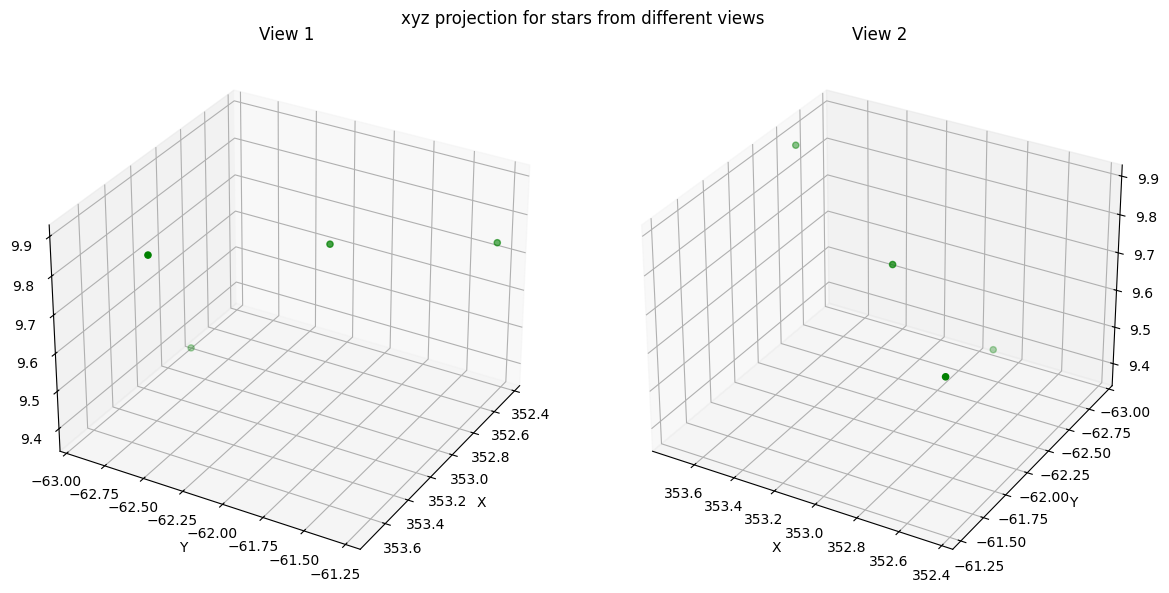

In [ ]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # set width ratio for each subplot
coords = torch.tensor(a)
# First subplot with one viewing angle
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='green')
ax1.view_init(30, 30)  # Set elevation and azimuth
ax1.set_title('View 1')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Second subplot with another viewing angle
ax2 = fig.add_subplot(gs[1], projection='3d')
ax2.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='green')
ax2.view_init(30, 120)  # Different elevation and azimuth
ax2.set_title('View 2')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.suptitle('xyz projection for stars from different views')
plt.tight_layout()
plt.show()

In [ ]:
df = pl.DataFrame({"foo": [1, 2, 3], "bar": [-1, 5, 8]})